# 🎬 Movie Revenue Prediction – TMDB Dataset


## 1. Data Source and Quality


The data used in this project is a union between the **TMDB (The Movie Database) API** and **Kaggle** (see below). The TMDB API ensures **structured and up-to-date information**, though the data may still contain missing values, inconsistencies in financial reporting, and variations in how production countries or languages are recorded.

---

> **Attribution**: *This product uses the TMDB API but is not endorsed or certified by TMDB.*


*Note: The data import and preprocessing pipeline has been modularized into separate `.py` scripts for better scalability and reusability. This notebook focuses on the exploration and modeling phase.*

In [1]:
# --- Configuration ---
from movie_revenue_prediction.api.tmdb_client import TMDBClient
import shutil
import pandas as pd
import numpy as np
from pathlib import Path

from movie_revenue_prediction.utils.functions import  list_columns_to_pipe
from movie_revenue_prediction.features.build_features import run_core_enrichment_pipeline
# import os, getpass
# os.environ["TMDB_KEY"] = getpass.getpass("TMDB API key: ")


In [2]:
import os
# Use CPU to avoid Metal/MPS crashes; slower but very stable
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  
# (Optional) quieter logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
try:
    tf.config.set_visible_devices([], "GPU")  
except Exception:
    pass
# Make TF deterministic-ish and lighter
tf.random.set_seed(42)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)



### API Data


As mentioned before, the project uses data from the [TMDB (The Movie Database) API](https://developer.themoviedb.org/).  

**How the API Call Works**
The `API_call.py` module handles all data retrieval and enrichment:
- It queries TMDB for movies released between the specified years (`YEAR_START`, `YEAR_END`)  
- For each movie, it fetches details, credits, release certifications, and keywords  
- The data is then processed into a clean and feature-enriched DataFrame ready for modeling  

All requests are rate-limited and retried safely to comply with TMDB’s usage policy.


In [4]:
# Used to retrieve ids

# from API_call import TMDBClient, build_minimal_dataset
# client = TMDBClient.from_env()

# known_ids = ids["id"].unique().tolist()   # or load from file

# df_new = build_minimal_dataset(
#     client,
#     YEAR_START=2017,
#     YEAR_END=2025,
#     MAX_PAGES_PER_YEAR=500,
#     include_adult=False,
#     sort_by="revenue.desc",   # bias toward populated revenue
#     exclude_ids=known_ids,    # <-- skip those
#     only_released=True,
#     workers=12,
#     show_progress=True,
# )



Discovered ~9,999 ids up to year 2017
Discovered ~19,999 ids up to year 2018
Discovered ~29,999 ids up to year 2019
Discovered ~39,999 ids up to year 2020
Discovered ~49,996 ids up to year 2021
Discovered ~59,996 ids up to year 2022
Discovered ~69,996 ids up to year 2023
Discovered ~79,995 ids up to year 2024
Discovered ~89,990 ids up to year 2025
Excluded 28,160 known ids → 89,982 → 71,772 to fetch
Fetched 1,000/71,772
Fetched 2,000/71,772
Fetched 3,000/71,772
Fetched 4,000/71,772
Fetched 5,000/71,772
Fetched 6,000/71,772
Fetched 7,000/71,772
Fetched 8,000/71,772
Fetched 9,000/71,772
Fetched 10,000/71,772
Fetched 11,000/71,772
Fetched 12,000/71,772
Fetched 13,000/71,772
Fetched 14,000/71,772
Fetched 15,000/71,772
Fetched 16,000/71,772
Fetched 17,000/71,772
Fetched 18,000/71,772
Fetched 19,000/71,772
Fetched 20,000/71,772
Fetched 21,000/71,772
Fetched 22,000/71,772
Fetched 23,000/71,772
Fetched 24,000/71,772
Fetched 25,000/71,772
Fetched 26,000/71,772
Fetched 27,000/71,772
Fetched 28,0

**Note:** The data imported directly with TMDB API call is incomplete. Around 75% or movies for each year have 0 budget and revenue. 
These missing values can be due to multiple factors:
- Budget confidentiality: studios rarely disclose full costs publicly.
- Revenue delayed: box office updates lag, especially for streaming releases.
- Placeholder zeros: TMDB sometimes stores 0 for unknown, not missing.
- Non-theatrical releases: streaming exclusives, indie films, and documentaries often don’t have box office figures at all.


To speed up the process, we could use the data available from **Kaggle** and union the datasets.

**Note:** We limit the dataset to movies from 2017 to 2024. This way, we try to find a balance between data volume and market relevance.  
For illustrating the models' performance, we will keep the movies from 2025 (particularly the 'Released' ones) in another dataset.

There are a few drawbacks regarding this selection:
- includes COVID period where we can see unreliable revenues, delayed releases and huge outliers;
- one might argue that if the aim is to predict future (2025) movies' revenue, the data should contain more recent movies only. Nonetheless, we try to also have a model which can generalise and enough data for this purpose.

### Kaggle data
Now, let us import the TMDB datasets from Kaggle. The idea is to find unique Movie IDs, for which Revenue and Budget is >0. Then, we use the API to add the additional feature.

In [4]:

# data_dir = Path("you_path")

# # Get all .csv files in the folder 
# csv_files = sorted(data_dir.glob("*.csv"))
# if not csv_files:
#     raise FileNotFoundError(f"No CSV files found in {data_dir}")

# print(f" Found {len(csv_files)} CSV files:")
# for f in csv_files:
#     print(f" - {f.name}")
# df_list = [pd.read_csv(f) for f in csv_files]

# # Find common columns across all dataframes 
# common_cols = set(df_list[0].columns)
# for df in df_list[1:]:
#     common_cols &= set(df.columns)

# common_cols = sorted(common_cols)
# print(f"\n Found {len(common_cols)} common columns across all CSVs.")

# df_list_common = [df[common_cols] for df in df_list]
# df_kaggle = pd.concat(df_list_common, ignore_index=True)

# # Remove duplicate IDs if column 'id' exists 
# if "id" in df_kaggle.columns:
#     before_dupes = len(df_kaggle)
#     df_kaggle = df_kaggle.drop_duplicates(subset="id", keep="first")
#     after_dupes = len(df_kaggle)
#     removed_dupes = before_dupes - after_dupes
#     print(f" Removed {removed_dupes:,} duplicate rows based on 'id'.")
# else:
#     print(" Column 'id' not found — skipping duplicate removal.")

# print(f"\n Final shape: {df_kaggle.shape}")
# print(" Columns kept:", common_cols)
# display(df_kaggle.head(3))



 Found 5 CSV files:
 - TMDB  IMDB Movies Dataset.csv
 - TMDB_all_movies.csv
 - TMDB_movie_dataset_v11.csv
 - tmdb-movies.csv
 - tmdb_5000_movies.csv

 Found 13 common columns across all CSVs.
 Removed 1,576,913 duplicate rows based on 'id'.

 Final shape: (1314434, 13)
 Columns kept: ['budget', 'genres', 'id', 'original_title', 'overview', 'popularity', 'production_companies', 'release_date', 'revenue', 'runtime', 'tagline', 'vote_average', 'vote_count']


,budget,genres,id,original_title,overview,popularity,production_companies,release_date,revenue,runtime,tagline,vote_average,vote_count
0,160000000.0,"Action, Science Fiction, Adventure",27205,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,"Legendary Pictures, Syncopy, Warner Bros. Pict...",2010-07-15,8.255328e+08,148.0,Your mind is the scene of the crime.,8.364,34495.0
1,165000000.0,"Adventure, Drama, Science Fiction",157336,Interstellar,The adventures of a group of explorers who mak...,140.241,"Legendary Pictures, Syncopy, Lynda Obst Produc...",2014-11-05,7.017292e+08,169.0,Mankind was born on Earth. It was never meant ...,8.417,32571.0
2,185000000.0,"Drama, Action, Crime, Thriller",155,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,"DC Comics, Legendary Pictures, Syncopy, Isobel...",2008-07-16,1.004558e+09,152.0,Welcome to a world without rules.,8.512,30619.0


The next step is to work on columns: 
- Import the missing features based on ID
- Remove rows where budget and revenue are lower than 100

In [5]:
# df_kaggle["id"] = pd.to_numeric(df_kaggle["id"], errors="coerce")
# df_kaggle = df_kaggle.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# df_kaggle["release_date"] = pd.to_datetime(df_kaggle["release_date"], errors="coerce")
# df_kaggle["release_year"] = df_kaggle["release_date"].dt.year
# df_kaggle = df_kaggle[(df_kaggle["release_year"].between(2017, 2025, inclusive="both")) ].copy()


(429971, 14)

### Final raw dataset

In [6]:
# All ids
ids = pd.read_csv('data/raw/ids.csv')
ids["id"] = pd.to_numeric(ids["id"], errors="coerce")
ids["budget"] = pd.to_numeric(ids["budget"], errors="coerce")
ids["revenue"] = pd.to_numeric(ids["revenue"], errors="coerce")

ids = ids[
    (ids["budget"] > 0) &
    (ids["revenue"] > 0)
].copy()

ids["id"] = pd.to_numeric(ids["id"], errors="coerce")


/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_44650/54265153.py:2: DtypeWarning: Columns (2,11,12,13,14,15,16,17,18,19,20,21,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ids = pd.read_csv('data/raw/ids.csv')


(5708, 26)

In [13]:
# For fetching all necessary fields

client = TMDBClient.from_env()

df_all = run_core_enrichment_pipeline(
        df_union=ids,
        top_cast_k=3,
        workers=10,
        drop_thresholds=(100, 100),
        priority_countries=("US","GB"),
        overwrite_title=True,         # keep input 'title', fill only if missing
        show_progress=True,
    )

print("\nFinal schema & dtypes:\n", df_all.dtypes)
display(df_all.head(10))

Core enrichment: fetching 3,764 movies (top_cast_k=3, workers=10)


In [16]:
# df_all = pd.read_csv('data/curated/all_ids_dataset.csv')

df_all = list_columns_to_pipe(df_all, ['genres', 'production_countries', 'spoken_languages','keywords', 'directors', 'lead_cast', 'lead_cast_genders', 'composers'])
df_all["is_in_collection"] = np.where(df_all["collection_name"].fillna("").str.strip() != "", 1, 0)

df_all["release_date"] = pd.to_datetime(df_all["release_date"], errors="coerce")
df_all["release_year"] = df_all["release_date"].dt.year
df_all =  df_all[
    (df_all["release_year"].between(2017, 2025, inclusive="both")) & (df_all["budget"]> 100) & (df_all["revenue"]> 100)
].copy()
df_2025 = df_all.copy()

df_2025 = df_2025[df_2025["release_year"] == 2025]
df_2025.shape

(388, 29)

In [17]:

df_2017_2024 = df_all.copy()

# Only 2017-2024 
df_2017_2024 = df_2017_2024[
    (df_2017_2024["release_year"].between(2017, 2024, inclusive="both")) 
].copy()

total = len(df_all)
kept = len(df_2017_2024)
removed = total - kept

print(f"Total movies before filtering: {total:,}")
print(f"Movies after filtering: {kept:,}")
print(f"Removed: {removed:,} ({removed/total*100:.2f}% dropped)\n")

# Distribution by year
print("Movies per year after filtering:")
print(
    df_2017_2024["release_year"]
    .value_counts()
    .sort_index()
    .to_frame("count")
)
df_enriched=df_all.copy()
display(df_2017_2024.head(3))

Total movies before filtering: 3,505
Movies after filtering: 3,117
Removed: 388 (11.07% dropped)

Movies per year after filtering:
              count
release_year       
2017            468
2018            455
2019            386
2020            232
2021            290
2022            332
2023            471
2024            483


,id,title,title_api,original_title,release_date,revenue,budget,runtime,certification,genres,...,collection_name,avg_cast_popularity,homepage,popularity,vote_count,vote_average,composers,has_homepage,is_in_collection,release_year
0,354912,Coco,Coco,Coco,2017-10-27,814641172,175000000,105,PG,Family|Animation|Music|Adventure,...,Coco Collection,1.909133,https://www.pixar.com/feature-films/coco,37.2620,20402,8.200,Michael Giacchino|Baraka May|George Doering|Br...,1,1,2017
1,398175,Brawl in Cell Block 99,Brawl in Cell Block 99,Brawl in Cell Block 99,2017-09-23,64453,10000000,132,NR,Action|Crime|Thriller,...,NaN,2.297400,NaN,3.5764,1504,6.965,S. Craig Zahler|Jeff Herriott|Dallas Sonnier|D...,0,0,2017
2,346364,It,It,It,2017-09-06,704242888,35000000,135,R,Horror|Thriller,...,It Collection,4.674000,http://itthemovie.com/,25.8315,19779,7.238,Benjamin Wallfisch|Stephen King|Chung Chung-ho...,1,1,2017


## 2. Exploratory Data Analysis

In [45]:
import re
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download("stopwords", quiet=False)
from nltk.corpus import stopwords
print("nltk and stopwords loaded successfully!")

sns.set_style("whitegrid")

# Helper function to split pipe-separated lists safely
def split_pipe(col): 
    return col.dropna().apply(lambda x: [s.strip() for s in str(x).split("|") if s.strip()])





nltk and stopwords loaded successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/newuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The following exploratory steps are performed in order to:
- learn more about the data;
- assess whether or not we can efficiently apply one hot encoding to categorical variables;
- identify correlation between features (later).

### Data types and missing values

Total movies in dataset: 3,505

All empty-like values standardized to NaN.



,dtype,missing_count,missing_percent
collection_name,object,2911,83.05
homepage,object,1638,46.73
keywords,object,781,22.28
certification,object,589,16.80
production_countries,object,436,12.44
num_spoken_languages,float64,323,9.22
spoken_languages,object,323,9.22
directors,object,204,5.82
genres,object,117,3.34
composers,object,117,3.34


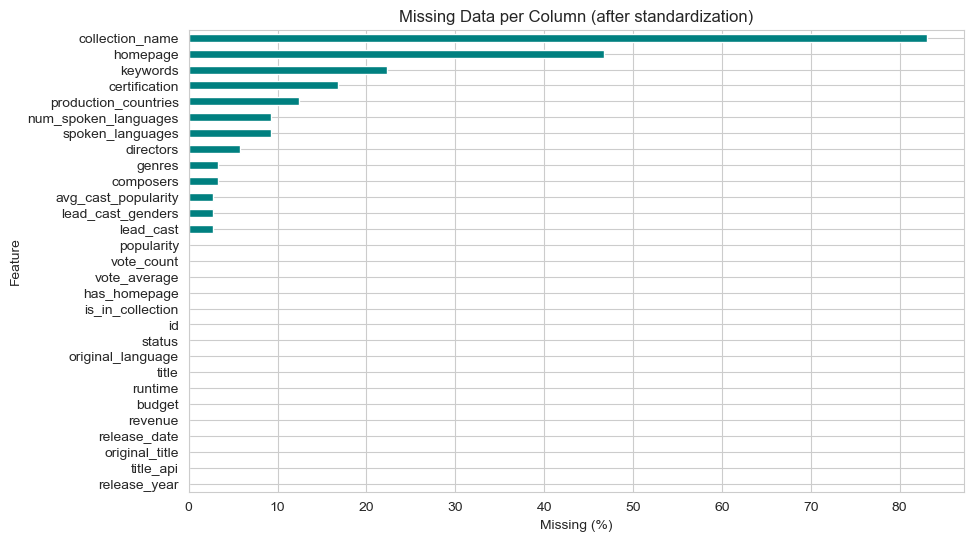

In [46]:
print(f"Total movies in dataset: {len(df_enriched):,}\n")

def standardize_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Replace None, 'None', empty strings, and empty lists/dicts with np.nan."""
    df_copy = df.copy()

    for col in df_copy.columns:
        # Convert explicit None/NaN/empty strings/"None" to np.nan
        df_copy[col] = df_copy[col].apply(
            lambda x: (
                np.nan
                if (
                    x is None
                    or (isinstance(x, float) and pd.isna(x))
                    or (isinstance(x, str) and x.strip().lower() in ["", "none", "nan"])
                    or (isinstance(x, (list, dict, set)) and len(x) == 0)
                )
                else x
            )
        )
    return df_copy

df_enriched_cleaned = standardize_missing_values(df_enriched)

print("All empty-like values standardized to NaN.\n")

def count_missing_robust(series: pd.Series) -> int:
    """Counts true NaN values only, since we've standardized everything."""
    return int(series.isna().sum())

eda_summary = pd.DataFrame({
    "dtype": df_enriched_cleaned.dtypes,
    "missing_count": [count_missing_robust(df_enriched_cleaned[c]) for c in df_enriched_cleaned.columns],
})

eda_summary["missing_percent"] = (
    eda_summary["missing_count"] / len(df_enriched_cleaned) * 100
).round(2)



eda_summary = eda_summary.sort_values("missing_percent", ascending=False)
display(eda_summary)

# --- 6️⃣ Plot missing percentages ---
plt.figure(figsize=(10,6))
eda_summary["missing_percent"].plot(kind="barh", color="teal")
plt.xlabel("Missing (%)")
plt.ylabel("Feature")
plt.title("Missing Data per Column (after standardization)")
plt.gca().invert_yaxis()
plt.show()

Multiple columns have missing data. The ones that might truly influence our data quality are: genres, certification, spoken_languages, production_countries, avg_cast_popularity, keywords. Nonetheless, we can not perform any imputing technique here as we are working with categorical features. Thus, we are choosing to keep the rows with missing values as we have limited observations for training.

### Categorical & Content Features

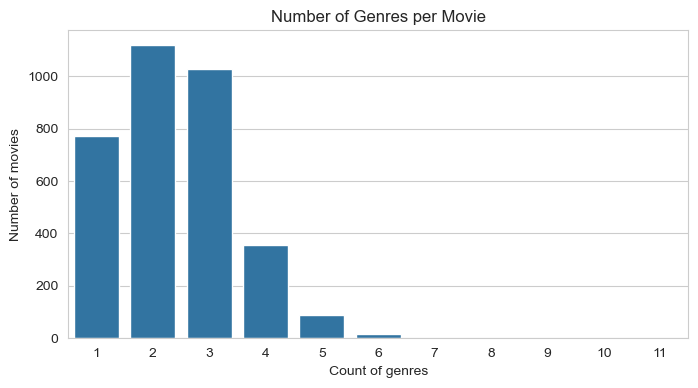

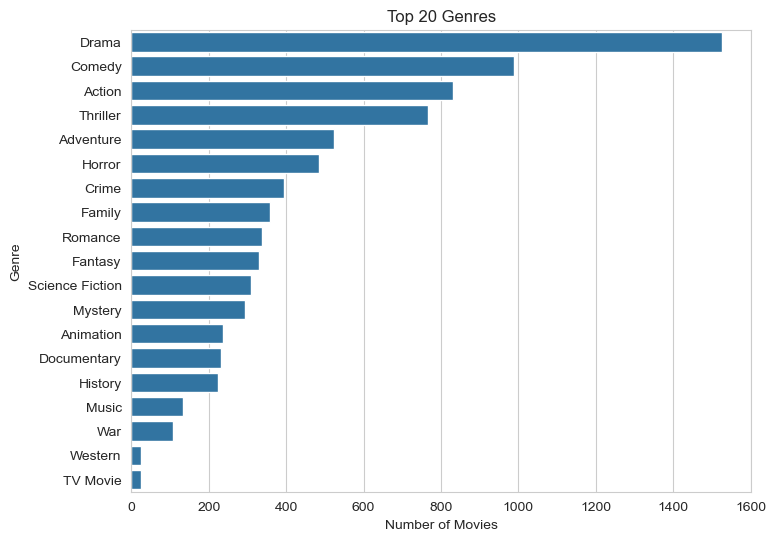

In [47]:
# Genres 
# ======================================================
genre_lists = split_pipe(df_enriched["genres"])
genre_count_per_movie = genre_lists.apply(len)

# Count number per movie
plt.figure(figsize=(8,4))
sns.countplot(x=genre_count_per_movie)
plt.title("Number of Genres per Movie")
plt.xlabel("Count of genres")
plt.ylabel("Number of movies")
plt.show()

# Top 20 genres
top_genres = genre_lists.explode().value_counts().head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title("Top 20 Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

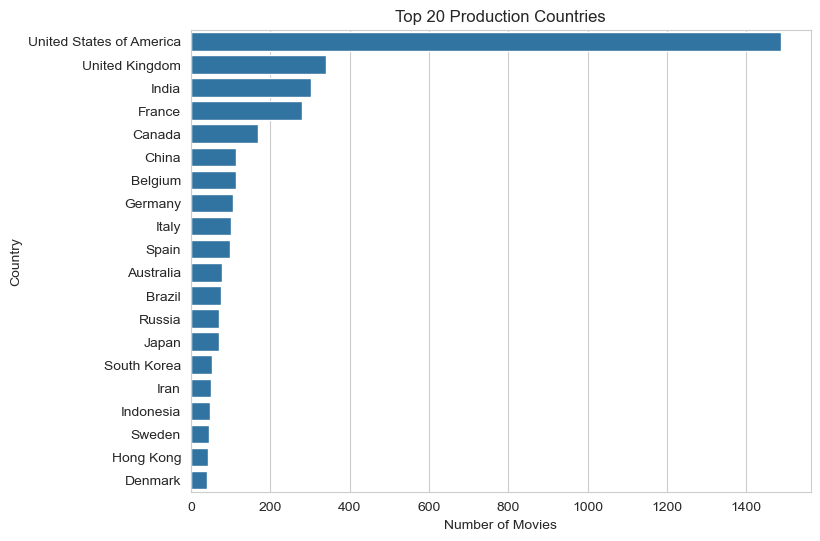

In [48]:
# Production countries — top 20
# ======================================================
country_lists = split_pipe(df_enriched["production_countries"])
top_countries = country_lists.explode().value_counts().head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 20 Production Countries")
plt.xlabel("Number of Movies")
plt.ylabel("Country")
plt.show()

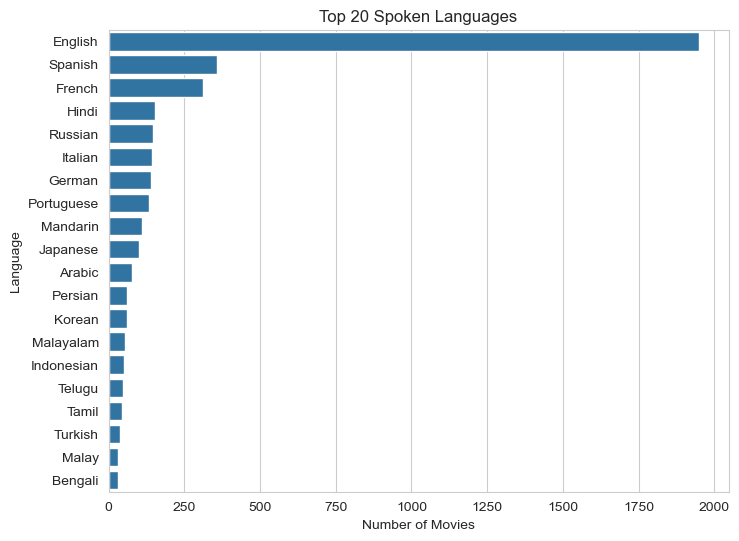

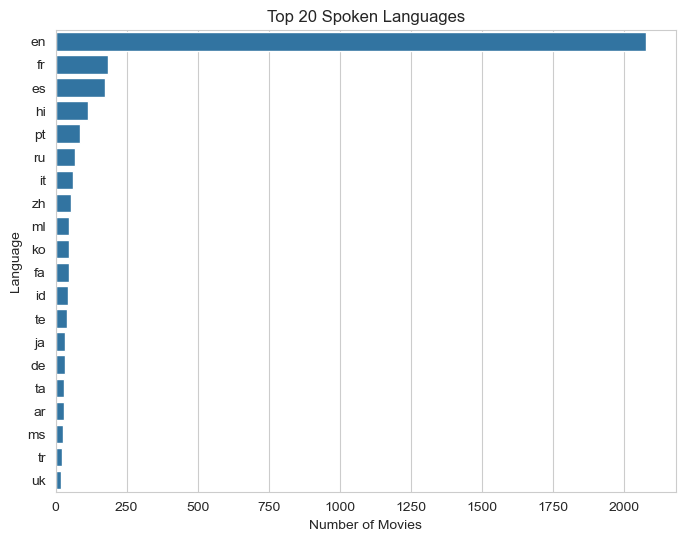

In [49]:
# Spoken languages — top 20
# ======================================================
lang_lists = split_pipe(df_enriched["spoken_languages"])
top_langs = lang_lists.explode().value_counts().head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top_langs.values, y=top_langs.index)
plt.title("Top 20 Spoken Languages")
plt.xlabel("Number of Movies")
plt.ylabel("Language")
plt.show()

lang_lists = split_pipe(df_enriched["original_language"])
top_langs = lang_lists.explode().value_counts().head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top_langs.values, y=top_langs.index)
plt.title("Top 20 Spoken Languages")
plt.xlabel("Number of Movies")
plt.ylabel("Language")
plt.show()

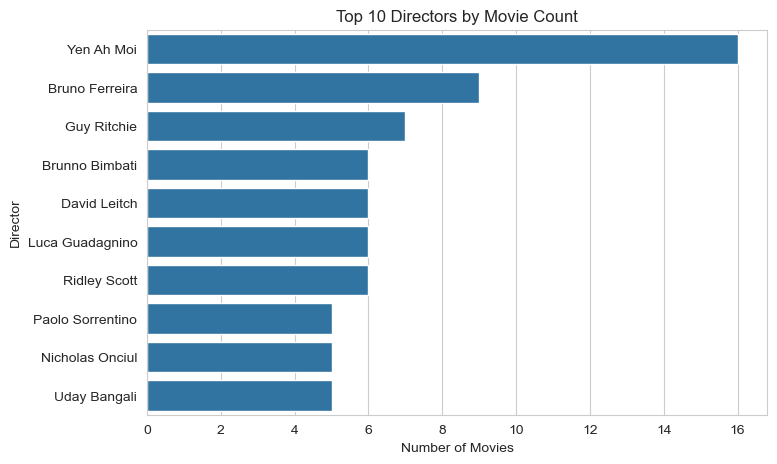

In [50]:
# Directors — top 10
# ======================================================
director_lists = split_pipe(df_enriched["directors"])
top_directors = director_lists.explode().value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_directors.values, y=top_directors.index)
plt.title("Top 10 Directors by Movie Count")
plt.xlabel("Number of Movies")
plt.ylabel("Director")
plt.show()

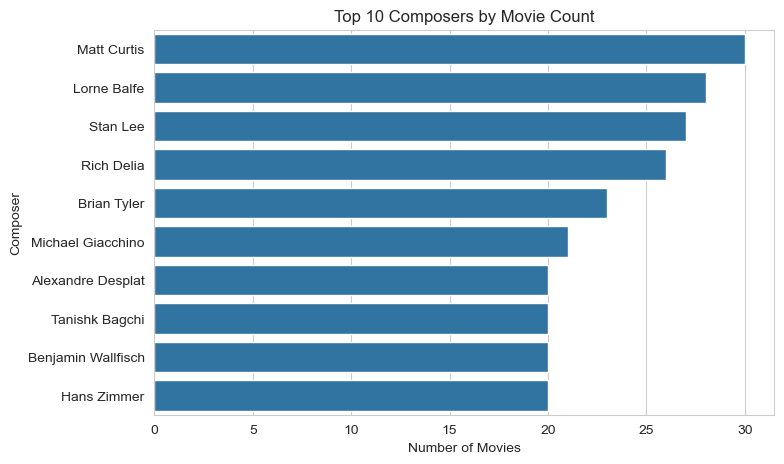

In [51]:
# Composers — top 10
# ======================================================
director_lists = split_pipe(df_enriched["composers"])
top_directors = director_lists.explode().value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_directors.values, y=top_directors.index)
plt.title("Top 10 Composers by Movie Count")
plt.xlabel("Number of Movies")
plt.ylabel("Composer")
plt.show()

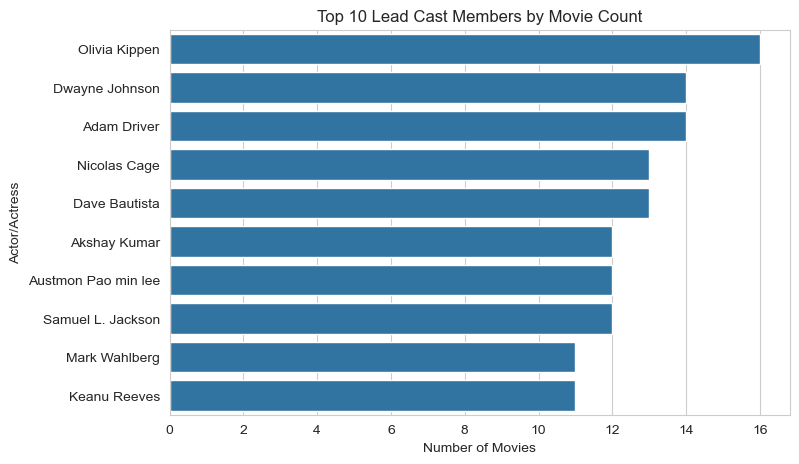

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/3228276418.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel")


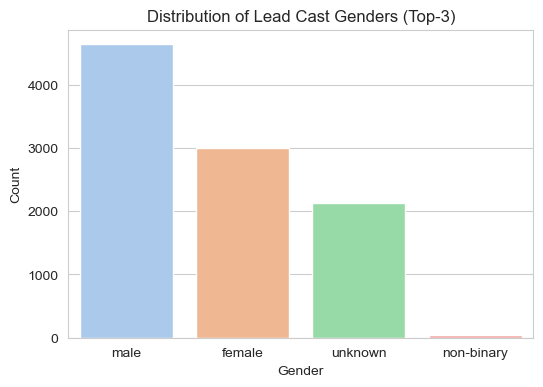

In [52]:
# Lead cast — top 10
# ======================================================
lead_cast_lists = split_pipe(df_enriched["lead_cast"])
top_cast = lead_cast_lists.explode().value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_cast.values, y=top_cast.index)
plt.title("Top 10 Lead Cast Members by Movie Count")
plt.xlabel("Number of Movies")
plt.ylabel("Actor/Actress")
plt.show()

# Gender distribution
gender_lists = split_pipe(df_enriched["lead_cast_genders"])
gender_counts = gender_lists.explode().value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel")
plt.title("Distribution of Lead Cast Genders (Top-3)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

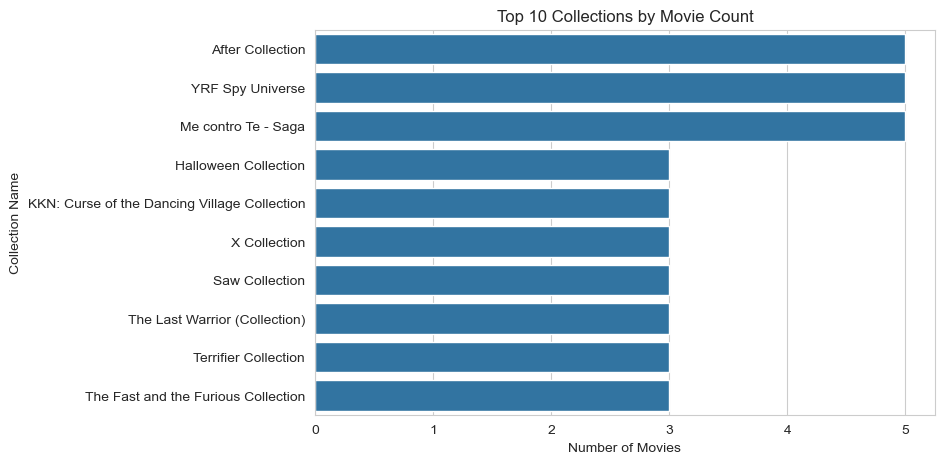

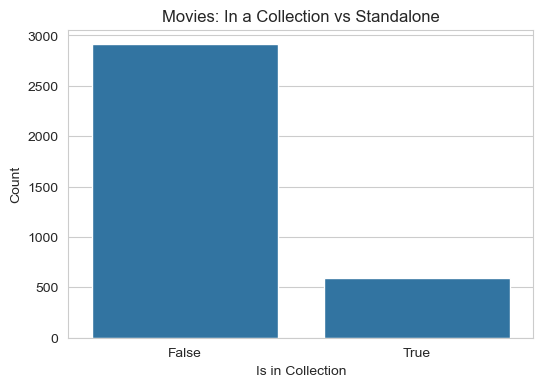

In [53]:
# Collections — top 10 names
# ======================================================
collection_counts = df_enriched["collection_name"].dropna().value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=collection_counts.values, y=collection_counts.index)
plt.title("Top 10 Collections by Movie Count")
plt.xlabel("Number of Movies")
plt.ylabel("Collection Name")
plt.show()

# In/not in collection
plt.figure(figsize=(6,4))
sns.countplot(x=df_enriched["is_in_collection"].astype(bool))
plt.title("Movies: In a Collection vs Standalone")
plt.xlabel("Is in Collection")
plt.ylabel("Count")
plt.show()

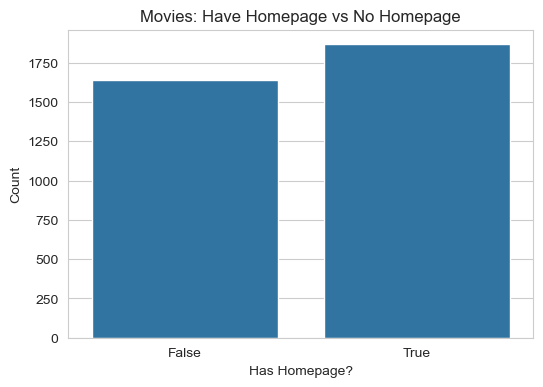

In [54]:
# Homepage presence
# ======================================================
plt.figure(figsize=(6,4))
sns.countplot(x=df_enriched["has_homepage"].astype(bool))
plt.title("Movies: Have Homepage vs No Homepage")
plt.xlabel("Has Homepage?")
plt.ylabel("Count")
plt.show()


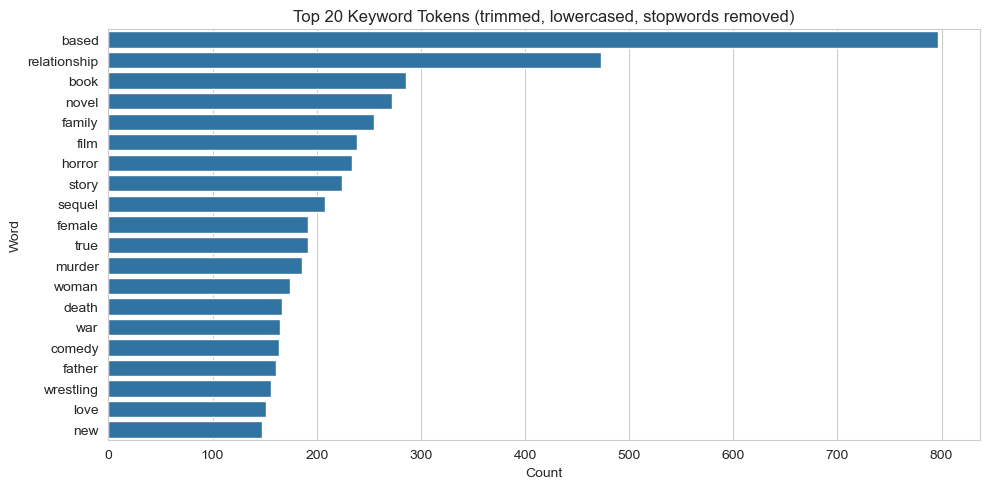

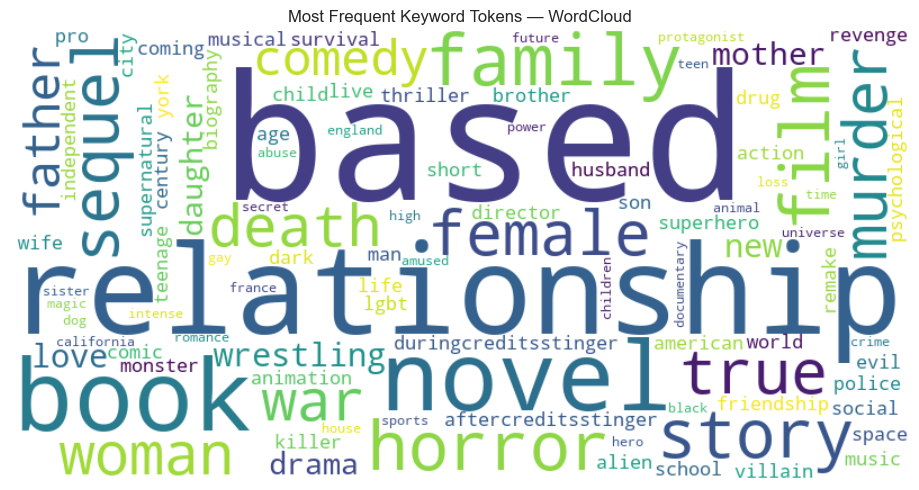

In [55]:
# Keywords — clean → tokenize (by word) → remove stopwords → Top 20
# ======================================================
import sys, subprocess, re
from collections import Counter

# --- Safe imports (install if missing in the active kernel) ---
def ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

ensure("nltk")
ensure("matplotlib")
ensure("seaborn")
# wordcloud is optional; we'll try to import later and skip if not available

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# make sure stopwords are available
try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords", quiet=True)

stop_words = set(stopwords.words("english"))

# Tokenizer: keep alphanumerics; split hyphenated/compound into words
token_re = re.compile(r"[A-Za-z0-9]+")

def preprocess_keywords_as_words(text_series):
    words = []
    for txt in text_series.dropna():
        # split pipe-separated keywords first, then tokenize each keyword into words
        for kw in str(txt).split("|"):
            kw = kw.strip().lower()           # trim + lowercase
            if not kw:
                continue
            for tok in token_re.findall(kw):  # tokenize into words
                if not tok:
                    continue
                if tok.isdigit():            # drop pure numbers
                    continue
                if tok in stop_words:        # remove stopwords
                    continue
                words.append(tok)
    return words

keywords_all_words = preprocess_keywords_as_words(df_enriched["keywords"])
top_keywords = Counter(keywords_all_words).most_common(20)
top_keywords100 = Counter(keywords_all_words).most_common(100)


# --- Bar chart of top 20 word tokens ---
if top_keywords:
    kw, freq = zip(*top_keywords)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(freq), y=list(kw))
    plt.title("Top 20 Keyword Tokens (trimmed, lowercased, stopwords removed)")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()
else:
    print("No keyword tokens found after cleaning.")

# --- Optional word cloud (skip if wordcloud isn't available) ---
try:
    from wordcloud import WordCloud
    if top_keywords100:
        wc = WordCloud(width=800, height=400, background_color="white") \
             .generate_from_frequencies(dict(top_keywords100))
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title("Most Frequent Keyword Tokens — WordCloud")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("WordCloud not shown (missing package or another issue):", e)

Based on the above plots, we can conclude that there is no interest into applying one hot encoding to Directors,Composers, Collections or Lead Cast columns. This is due to limited count of movies in Top 5. For instance, for the most frequent Lead Cast actor (Olivia Kippen), we only have 16 movies. Such sparse features would not allow the models to generalize and would add non-significant noise. The possibility of creating derived features will be furthermore discussed in the next part.
In the case of Gender Cast distribution, we could create a new feature which would represent


### Quantitative Features

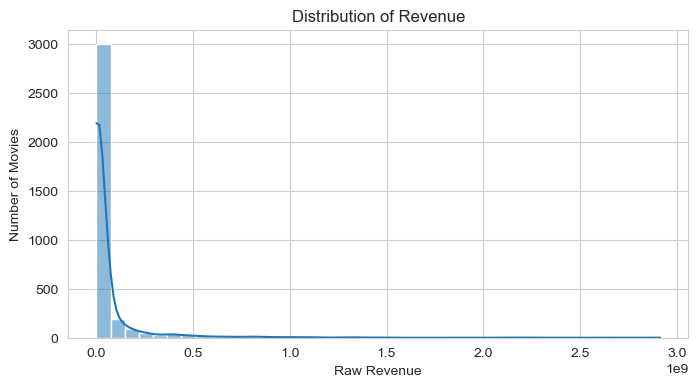

In [56]:
# Revenue distribution (binned)
# ======================================================
plt.figure(figsize=(8,4))
sns.histplot(df_enriched["revenue"], bins=40, kde=True)
plt.title("Distribution of Revenue")
plt.xlabel("Raw Revenue")
plt.ylabel("Number of Movies")
plt.show()

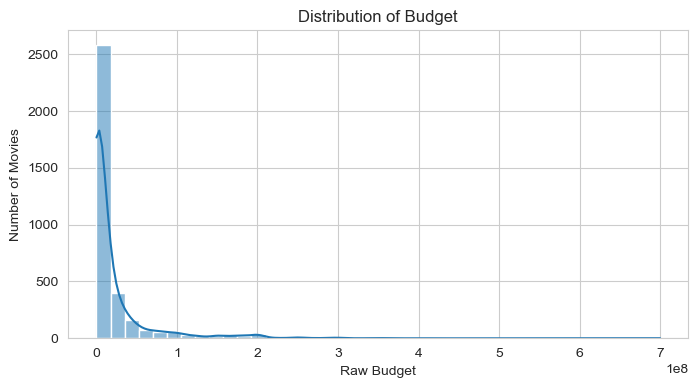

In [57]:
#  Budget distribution (binned)
# ======================================================
plt.figure(figsize=(8,4))
sns.histplot(df_enriched["budget"], bins=40, kde=True)
plt.title("Distribution of Budget")
plt.xlabel("Raw Budget")
plt.ylabel("Number of Movies")
plt.show()

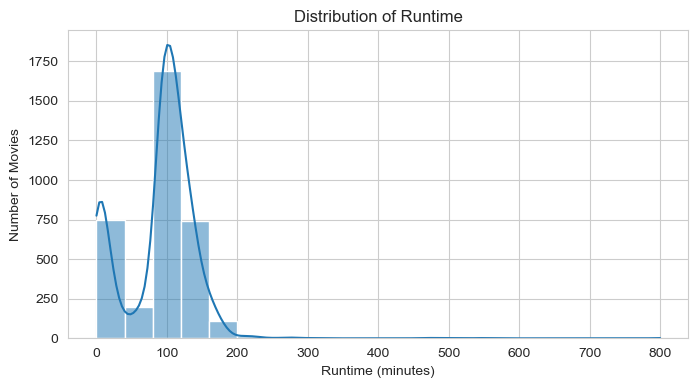

In [58]:
# Distribution of runtime
plt.figure(figsize=(8,4))
sns.histplot(df_enriched["runtime"], bins=20, kde=True)
plt.title("Distribution of Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Number of Movies")
plt.show()

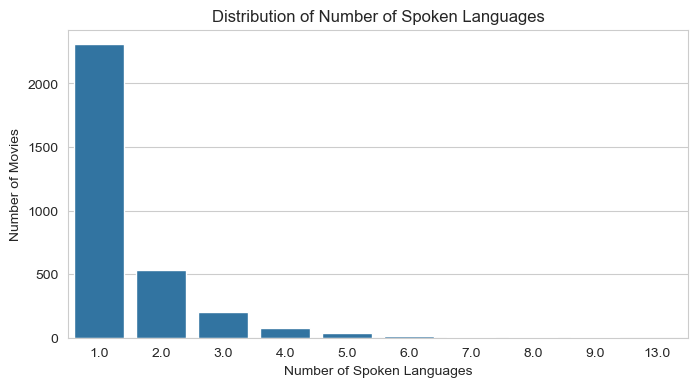

In [59]:
# Distribution of nr of spoken languages

plt.figure(figsize=(8,4))
sns.countplot(x=df_enriched["num_spoken_languages"])
plt.title("Distribution of Number of Spoken Languages")
plt.xlabel("Number of Spoken Languages")
plt.ylabel("Number of Movies")
plt.show()

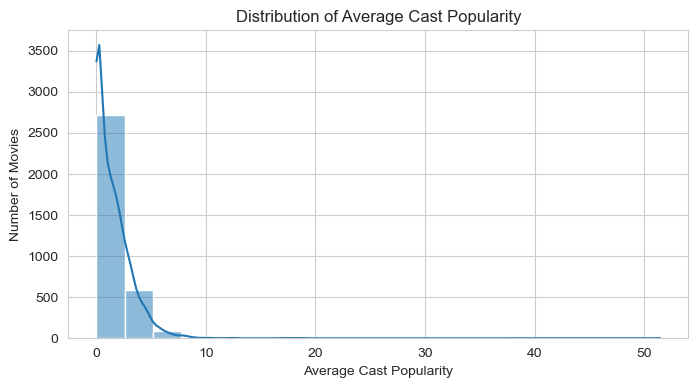

In [60]:
# Avg_cast_popularity distribution (binned)
# ======================================================
plt.figure(figsize=(8,4))
sns.histplot(df_enriched["avg_cast_popularity"], bins=20, kde=True)
plt.title("Distribution of Average Cast Popularity")
plt.xlabel("Average Cast Popularity")
plt.ylabel("Number of Movies")
plt.show()

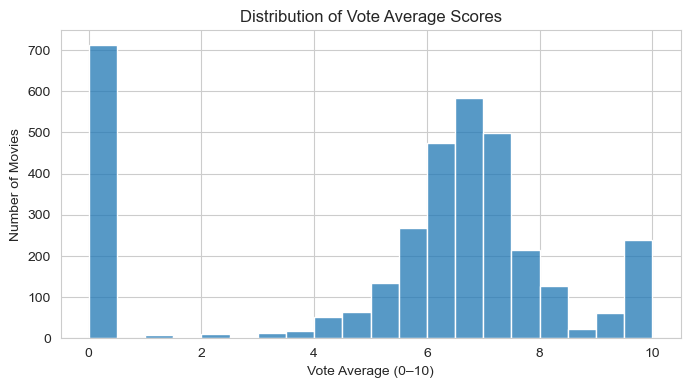

In [61]:
# Vote_average distribution (binned)
# ======================================================
plt.figure(figsize=(8,4))
sns.histplot(df_enriched["vote_average"], bins=np.arange(0,10.5,0.5), kde=False)
plt.title("Distribution of Vote Average Scores")
plt.xlabel("Vote Average (0–10)")
plt.ylabel("Number of Movies")
plt.show()

As expected, most numerical columns have a skewed distribution. We will not use vote avg or avg_cast_popularity as these features might lead to indirect information leakage. For instance, when a movie is released, we know nothing in terms of vote avg. Moreover, avg_cast_popularity is uses the current popularity score of the actor in TMDB’s database at the time you fetched the data. If you fetch both movies today, both will show the same actor popularity, because TMDB pulls that value from the actor’s person object as it exists now. 
We can also conclude that working with log for budget and revenue would be much more convenient for the models as not to compute large numbers.

### Temporal Analysis

In [62]:
sns.set_style("whitegrid")

df_time = df_enriched.copy()
df_time["release_date"] = pd.to_datetime(df_time["release_date"], errors="coerce")
df_time = df_time.dropna(subset=["release_date", "revenue"])
df_time = df_time[df_time["revenue"] > 0]

df_time["year"] = df_time["release_date"].dt.year
df_time["month"] = df_time["release_date"].dt.month
df_time["month_name"] = df_time["release_date"].dt.month_name().str.slice(stop=3)
df_time["weekday"] = df_time["release_date"].dt.day_name()
df_time["quarter"] = df_time["release_date"].dt.quarter

# --- Helper function for consistent plot style ---
def temporal_plot(x, y="revenue", data=None, agg="median", title="", xlabel="", ylabel="Revenue ($)", order=None, rotation=0):
    plt.figure(figsize=(10,5))
    sns.barplot(x=x, y=y, data=data, estimator=np.median if agg=="median" else np.mean, order=order, palette="coolwarm")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

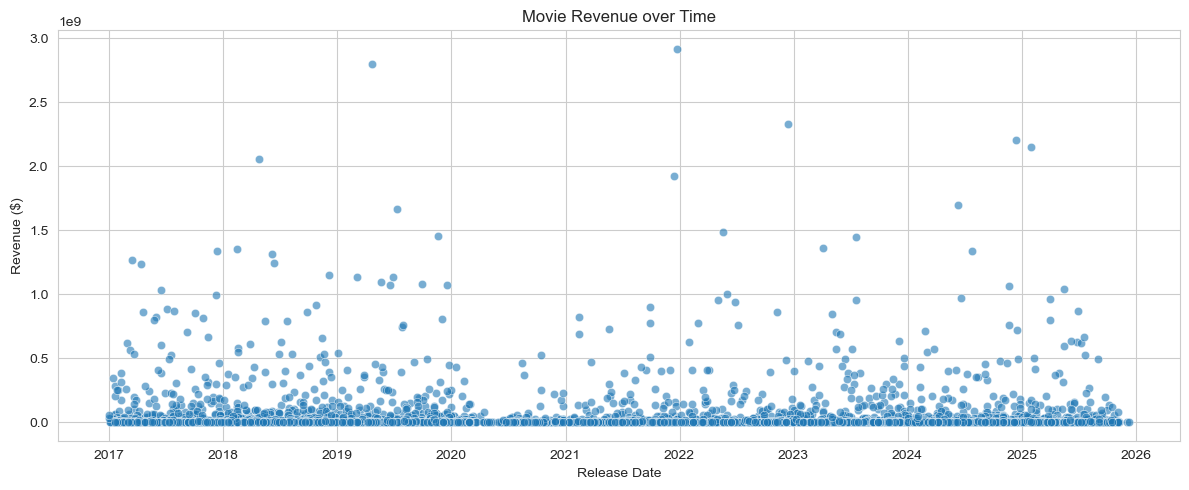

In [63]:

# Revenue vs Time (continuous timeline)
# ======================================================
plt.figure(figsize=(12,5))
sns.scatterplot(x="release_date", y="revenue", data=df_time, alpha=0.6)
plt.title("Movie Revenue over Time")
plt.xlabel("Release Date")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/3262686093.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=data, estimator=np.median if agg=="median" else np.mean, order=order, palette="coolwarm")


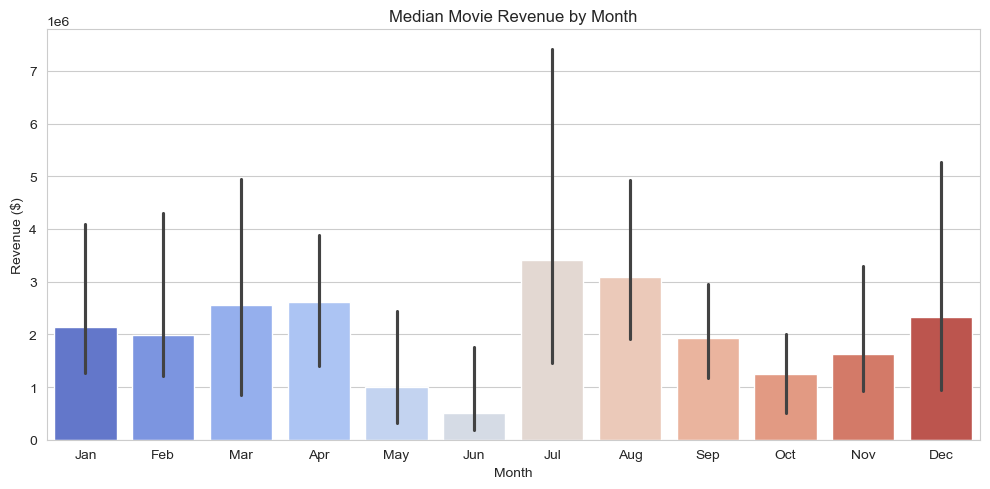

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/1920811858.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="month_name", data=df_time, order=month_order, palette="crest")


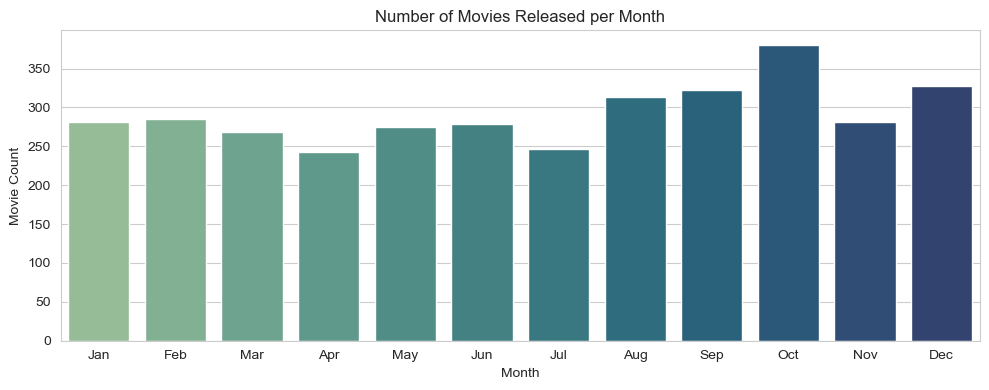

In [64]:
# Revenue by Month
# ======================================================
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

temporal_plot(
    x="month_name",
    data=df_time,
    agg="median",
    title="Median Movie Revenue by Month",
    xlabel="Month",
    order=month_order
)

plt.figure(figsize=(10,4))
sns.countplot(x="month_name", data=df_time, order=month_order, palette="crest")
plt.title("Number of Movies Released per Month")
plt.xlabel("Month")
plt.ylabel("Movie Count")
plt.tight_layout()
plt.show()

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/3262686093.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=data, estimator=np.median if agg=="median" else np.mean, order=order, palette="coolwarm")


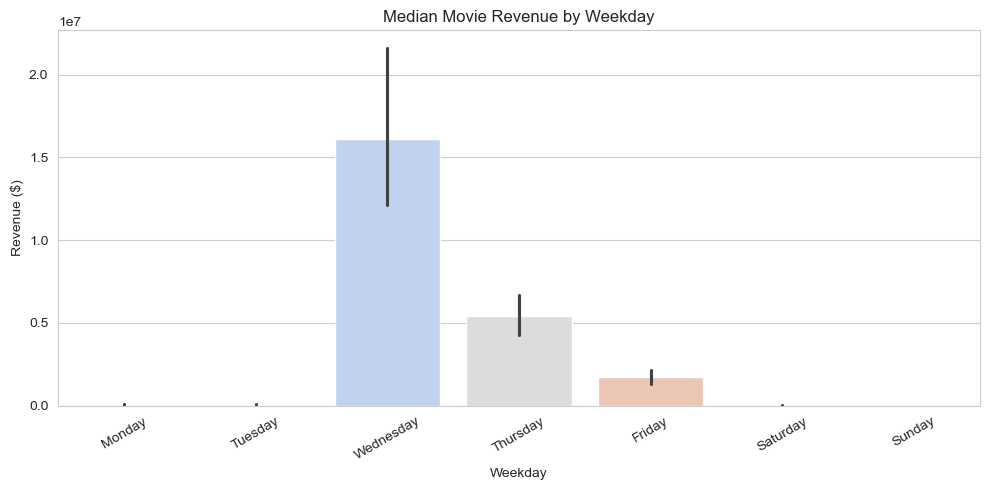

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/1010287259.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="weekday", data=df_time, order=weekday_order, palette="crest")


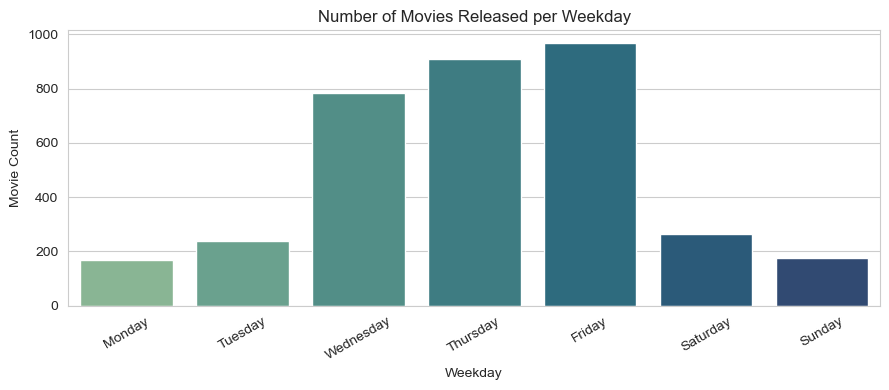

In [65]:
# Revenue by Weekday
# ======================================================
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

temporal_plot(
    x="weekday",
    data=df_time,
    agg="median",
    title="Median Movie Revenue by Weekday",
    xlabel="Weekday",
    order=weekday_order,
    rotation=30
)

plt.figure(figsize=(9,4))
sns.countplot(x="weekday", data=df_time, order=weekday_order, palette="crest")
plt.title("Number of Movies Released per Weekday")
plt.xlabel("Weekday")
plt.ylabel("Movie Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/3262686093.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=data, estimator=np.median if agg=="median" else np.mean, order=order, palette="coolwarm")


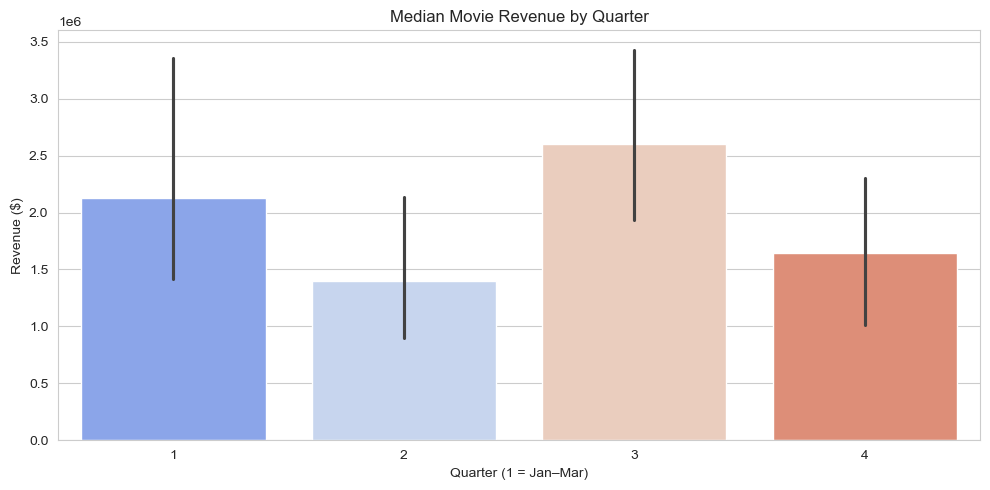

/var/folders/w2/s7f15lxs51zcy_sqpvy8rm480000gn/T/ipykernel_49983/3897730631.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="quarter", data=df_time, palette="crest")


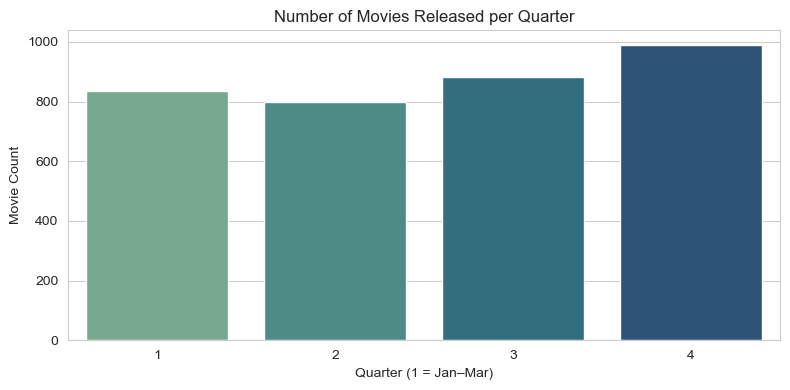

In [66]:
# Revenue by Quarter
# ======================================================
temporal_plot(
    x="quarter",
    data=df_time,
    agg="median",
    title="Median Movie Revenue by Quarter",
    xlabel="Quarter (1 = Jan–Mar)"
)

plt.figure(figsize=(8,4))
sns.countplot(x="quarter", data=df_time, palette="crest")
plt.title("Number of Movies Released per Quarter")
plt.xlabel("Quarter (1 = Jan–Mar)")
plt.ylabel("Movie Count")
plt.tight_layout()
plt.show()

As you can see, there are more movies released in Q4 and on Fridays. 
Movies released during the COVID pandemic have a lower revenue.

### ROI Outliers

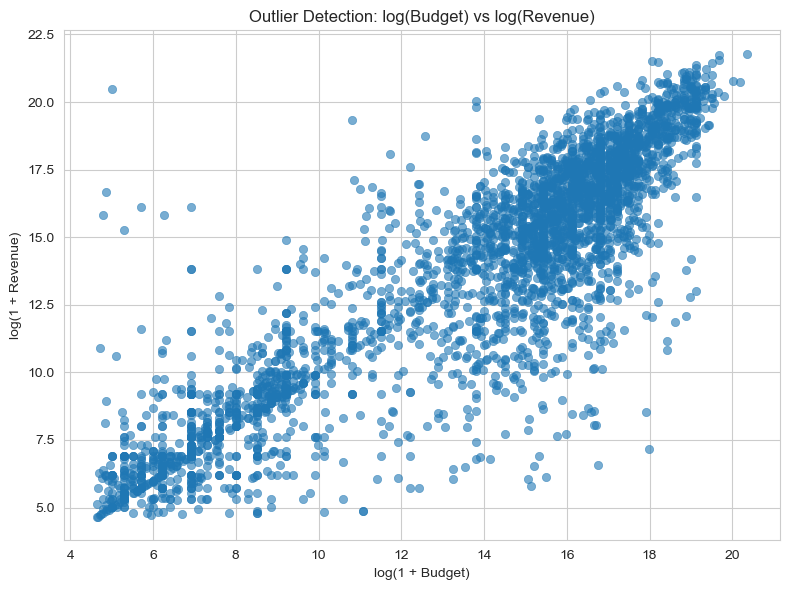

ROI Summary Statistics:


,ROI
count,3.505000e+03
mean,1.606943e+03
std,9.012134e+04
min,1.955725e-05
25%,4.866281e-01
50%,1.251854e+00
75%,3.223868e+00
90%,7.639756e+00
99%,1.000000e+02
max,5.333333e+06


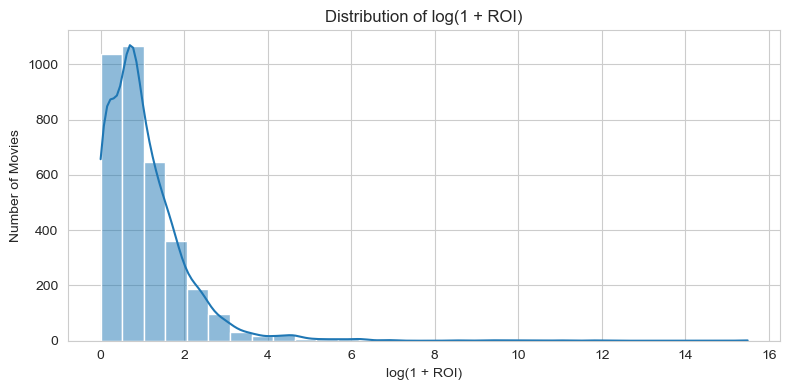


Top 5 Movies by ROI:


,title,budget,revenue,ROI
3243,The NeedyMonster,150,800000000,5.333333e+06
1707,"Dad, I'm Sorry",128,17130489,1.338319e+05
3545,Letters to Santa 5,119,7328061,6.158034e+04
2651,Meurtre Mystérieux à Montmartre,300,10000000,3.333333e+04
2250,GGXXACPR Community CMV 「Every time…」,199,4206974,2.114057e+04



Bottom 5 Movies by ROI:


,title,budget,revenue,ROI
1026,Society of the Snow,65500000,1281,0.000020
1164,Emmanuelle,19000000,712,0.000037
1125,Damsel,60000000,5000,0.000083
3664,The Ladykiller,5404446,456,0.000084
2241,Just a Couple of Days,3749000,331,0.000088


In [67]:
sns.set_style("whitegrid")

# Filter valid numeric entries only
df_fin = df_enriched.copy()
df_fin = df_fin.dropna(subset=["budget", "revenue"])
df_fin = df_fin[(df_fin["budget"] > 0) & (df_fin["revenue"] > 0)]

# Outlier Detection (Revenue vs Budget)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=np.log1p(df_fin["budget"]),
    y=np.log1p(df_fin["revenue"]),
    alpha=0.6,
    edgecolor=None
)
plt.title("Outlier Detection: log(Budget) vs log(Revenue)")
plt.xlabel("log(1 + Budget)")
plt.ylabel("log(1 + Revenue)")
plt.tight_layout()
plt.show()

# Compute ROI (return on investment)
df_fin["ROI"] = df_fin["revenue"] / df_fin["budget"]

# Describe ROI distribution
print("ROI Summary Statistics:")
display(df_fin["ROI"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).to_frame())

# Visualize ROI distribution (log scale)
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df_fin["ROI"]), bins=30, kde=True)
plt.title("Distribution of log(1 + ROI)")
plt.xlabel("log(1 + ROI)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

# Identify top and bottom outliers
top_outliers = df_fin.nlargest(5, "ROI")[["title", "budget", "revenue", "ROI"]]
low_outliers = df_fin.nsmallest(5, "ROI")[["title", "budget", "revenue", "ROI"]]
print("\nTop 5 Movies by ROI:")
display(top_outliers)
print("\nBottom 5 Movies by ROI:")
display(low_outliers)

Even if we took only observations with budget and revenue >0, there are still some extreme outliers with very high or very low ROI. This is due to a very low revenue or budget (most likely, incorrect entries).

### Budget–Revenue Consistency


35.7% of movies have revenue lower than their budget (loss-making).


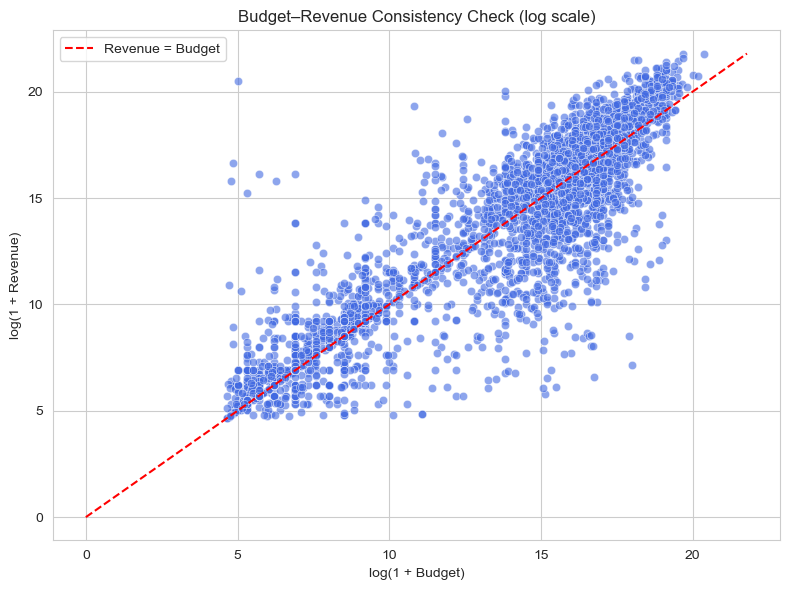

In [69]:
# Movies where revenue < budget (potential loss)
df_loss = df_fin[df_fin["revenue"] < df_fin["budget"]]
share_loss = len(df_loss) / len(df_fin) * 100

print(f"\n{share_loss:.1f}% of movies have revenue lower than their budget (loss-making).")

# Plot consistency line (Revenue = Budget)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=np.log1p(df_fin["budget"]),
    y=np.log1p(df_fin["revenue"]),
    alpha=0.6,
    color="royalblue"
)
# Reference line y = x
max_val = max(np.log1p(df_fin["budget"].max()), np.log1p(df_fin["revenue"].max()))
plt.plot([0, max_val], [0, max_val], "r--", label="Revenue = Budget")
plt.title("Budget–Revenue Consistency Check (log scale)")
plt.xlabel("log(1 + Budget)")
plt.ylabel("log(1 + Revenue)")
plt.legend()
plt.tight_layout()
plt.show()

Conclusion: The dataset has observations with too low budget and revenue, which seem to be imposible values like 700 dollars. One technique that we can apply to mitigate this issue is winsorization. This approach preserves all observations while stabilizing the model’s sensitivity to extreme cases.

A few benefits of winsorization:

- Prevents the model from overfitting to outliers that represent rare or erroneous cases.
- Forces the model to focus on the majority pattern rather than exceptions.
- Makes convergence more stable during training.
- Avoids biasing your dataset toward the “average” only.


#### Visual Comparison: ROI Before vs After Capping

ROI 1st percentile  = 0.001
ROI 99th percentile = 100.000
68 out of 3505 movies were capped (1.94%)
  - Below 1st percentile:  36
  - Above 99th percentile: 32


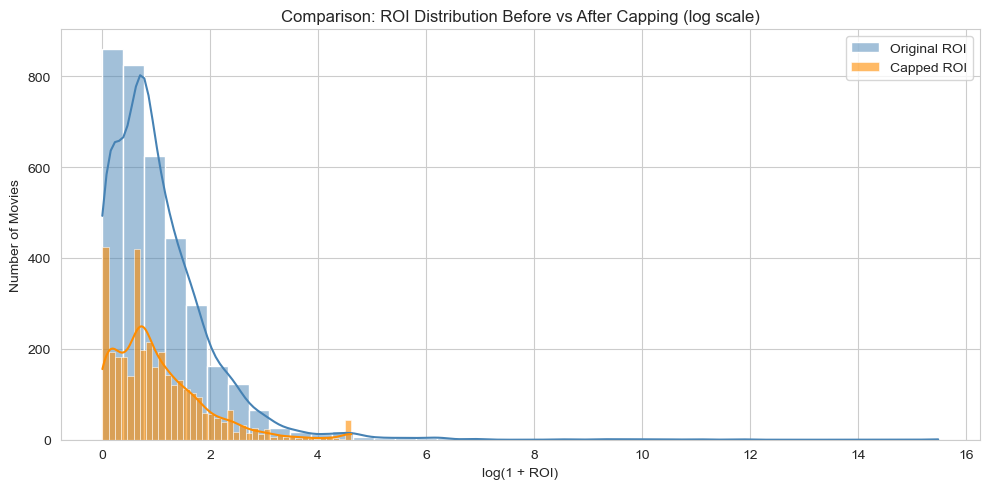

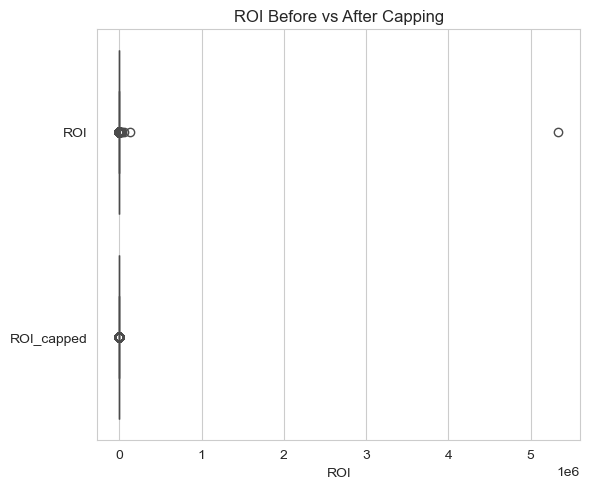

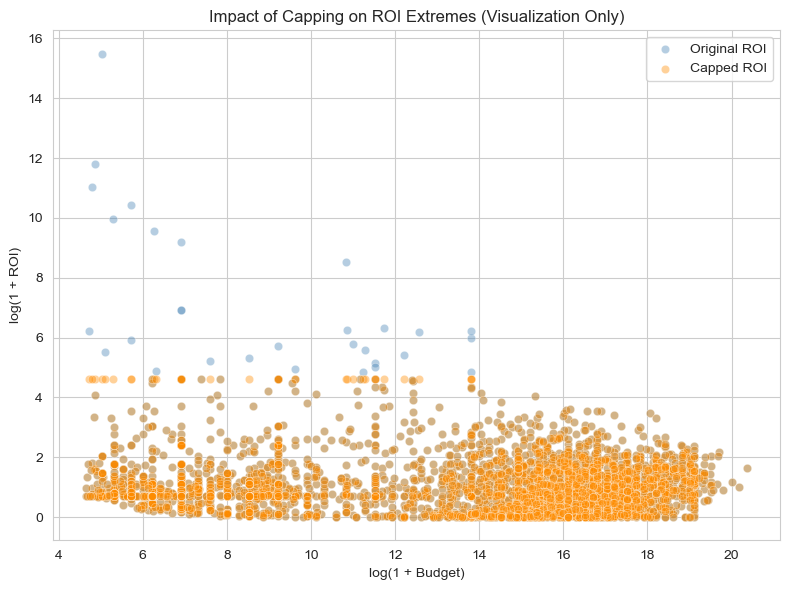

In [71]:
# ROI Capping Analysis
# ============================


sns.set_style("whitegrid")

# --- Create a copy for demonstration ---
df_cap_demo = df_fin.copy()
df_cap_demo["ROI"] = df_cap_demo["revenue"] / df_cap_demo["budget"]

# Compute 1st and 99th percentiles
low, high = df_cap_demo["ROI"].quantile([0.01, 0.99])

# Apply capping (copy only)
df_cap_demo["ROI_capped"] = df_cap_demo["ROI"].clip(lower=low, upper=high)

# --- Quantify how many values were capped ---
n_total = len(df_cap_demo)
n_low = (df_cap_demo["ROI"] < low).sum()
n_high = (df_cap_demo["ROI"] > high).sum()
pct_capped = (n_low + n_high) / n_total * 100

print(f"ROI 1st percentile  = {low:.3f}")
print(f"ROI 99th percentile = {high:.3f}")
print(f"{n_low + n_high} out of {n_total} movies were capped ({pct_capped:.2f}%)")
print(f"  - Below 1st percentile:  {n_low}")
print(f"  - Above 99th percentile: {n_high}")

# --- Visualize before vs after capping (distribution) ---
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df_cap_demo["ROI"]), color="steelblue", bins=40, label="Original ROI", kde=True)
sns.histplot(np.log1p(df_cap_demo["ROI_capped"]), color="darkorange", bins=40, label="Capped ROI", kde=True, alpha=0.6)
plt.title("Comparison: ROI Distribution Before vs After Capping (log scale)")
plt.xlabel("log(1 + ROI)")
plt.ylabel("Number of Movies")
plt.legend()
plt.tight_layout()
plt.show()

# --- Boxplot comparison ---
plt.figure(figsize=(6,5))
sns.boxplot(data=df_cap_demo[["ROI", "ROI_capped"]], orient="h", palette=["steelblue", "darkorange"])
plt.title("ROI Before vs After Capping")
plt.xlabel("ROI")
plt.tight_layout()
plt.show()

# --- Scatterplot comparison (budget vs ROI) ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=np.log1p(df_cap_demo["budget"]),
    y=np.log1p(df_cap_demo["ROI"]),
    alpha=0.4, color="steelblue", label="Original ROI"
)
sns.scatterplot(
    x=np.log1p(df_cap_demo["budget"]),
    y=np.log1p(df_cap_demo["ROI_capped"]),
    alpha=0.4, color="darkorange", label="Capped ROI"
)
plt.title("Impact of Capping on ROI Extremes (Visualization Only)")
plt.xlabel("log(1 + Budget)")
plt.ylabel("log(1 + ROI)")
plt.legend()
plt.tight_layout()
plt.show()

**Conclusion:**  
During initial experiments, winsorization (clipping the top and bottom 1% of budget and revenue) was applied to reduce the effect of outliers. However, this approach significantly distorted model performance when evaluating on future (2024) data. 
While the training-validation RMSE (on 2017–2023) remained low (≈ 2.3–2.4 in log-space), the test RMSE on 2024 movies increased sharply to ≈ 5.3, indicating poor generalization. Moreover, further inspection revealed that the winsorization thresholds—computed from past years—incorrectly truncated realistic blockbuster values, such as high-budget and high-revenue films.

Therefore, Based on the EDA, we conclude that the lower budget and revenue values are the faulty ones. Thus, we intend to cap the bottom only.
A light sanity check is also retained—dropping movies with clearly invalid data (e.g., budgets below $100 or revenues below $100). This preserves real-world blockbusters while filtering corrupted or placeholder records.

## 3. Feature Engineering and Train, validation, test sets


Before modeling, a thorough **data enrichment, cleaning, and feature engineering** process is applied to handle missing information, normalize features, and ensure the dataset is suitable for regression tasks.  
The make_features() function is applied on the dataset before splitting. The function does the following actions:

- Drops: popularity, vote_count, vote_average, collection_id, collection_name, avg_cast_popularity

- Creates: y_log_revenue, x_budget_log

- Expands release_date → x_year, x_month, x_weekday, x_weekofyear, x_day, x_quarter

- Keeps num_spoken_languages, runtime as numeric and also provides x_num_spoken_languages, x_runtime (since you asked that these start with x_)

- One-hot (top-N): genres, production_countries, spoken_languages, keywords → top 20; original_language → top 10; certification → top 20

- Ensures is_in_collection, has_homepage are 0/1 integers

- Adds gender ratios from lead_cast_genders: x_cast_ratio_male, x_cast_ratio_female, x_cast_ratio_nonbinary

- Keeps directors and lead_cast as-is (no OHE)

In [3]:
from movie_revenue_prediction.features.build_features import make_features_timeaware_splits
from movie_revenue_prediction.utils.functions import (winsorize_log_features, build_timeaware_prior_table, apply_timeaware_prior, high_corr_pairs)


df_union = pd.read_parquet('data/curated/tmdb_2017_2024.parquet')

train, val, test, feat_artifacts = make_features_timeaware_splits(
    df_union,
    train_end_year=2022,
    val_year=2023,
    test_start_year=2024,
    top_n_multi=20,
    top_n_orig_lang=10,
    top_n_cert=20,
)



Split sizes (rows): train=2163, val=471, test=483


Important features that were added:

- Categorical variables were one hot encoded on top 20 or top10 values;
- Continuous variables such as budget and revenue were log-transformed to stabilize variance and reduce skewness, given their broad numeric range and multiplicative relationship to revenue. Other numeric variables such as runtime and num_spoken_languages were retained in their original scale, as they exhibit limited range and approximate linear relationships with the target;
- The lead_cast_genders attribute, which lists the genders of the top-billed actors, was transformed into numeric features describing the gender composition of the cast. Ratios were computed for male, female, non-binary entries. This preserves the information about cast diversity and balance in a numeric form suitable for regression models;
- The make_features_timeware_splits takes into account the top k categorical values found in the train set and applies the same features to the other sets;
- To avoid temporal leakage and simulate real-world forecasting conditions, the dataset was split chronologically by release year rather than randomly.
Movies released between 2017–2022 were used for training, those from 2023 for validation, and those from 2024 for final testing.
This ensures that the model only learns from past data to predict future outcomes, aligning with a realistic production scenario.

In [6]:
# Compute stats
total = len(df_union)
splits = {
    "Train": len(train),
    "Validation": len(val),
    "Test": len(test),
}
for name, n in splits.items():
    print(f"{name:<12} {n:5d} movies  ({n/total*100:5.1f}%)")

Train         2163 movies  ( 69.4%)
Validation     471 movies  ( 15.1%)
Test           483 movies  ( 15.5%)


Changes and features to be made after splitting the dataset:

- Extreme values can disproportionately influence regression coefficients or decision splits, leading to unstable model behavior.To mitigate this effect, both budget and revenue variables were first log-transformed to stabilize variance and then Winsorized at the bottom 1%, computed only on the training subset.The resulting thresholds were then consistently applied to the validation and test sets to prevent information leakage from future data.

- To prevent temporal leakage, director, lead-cast and composer level reputation features were computed using only movies released prior to the training period. For example, when predicting revenues for 2024 releases, the average revenue per director was computed from films released up to 2023. This ensures that the model does not access future (test-period) information and mirrors a realistic forecasting setup.



In [9]:
# Winsorization
# Compute thresholds from training set
train_winsor, thresholds = winsorize_log_features(
    train,
    cols=["x_budget_log", "y_log_revenue"],
    q_low=0.01,
    q_high=None,        # <- important
    inplace=False,
    verbose=True,
)

# Apply same thresholds to all sets (train, val, test)
for df in [train, val, test]:
    for col, (ql, qh) in thresholds.items():
        df[col] = df[col].clip(lower=ql, upper=qh)


x_budget_log: capped 22 rows (1.02%) below 5.194
y_log_revenue: capped 15 rows (0.69%) below 5.303


Implementation summary:

- Applied to x_budget_log and y_log_revenue.

- Quantile limits estimated on training data.

- Same limits applied to validation and test data.

- Ensures consistent feature scaling and avoids leakage.

In [10]:
# Average revenue

# Build priors on TRAIN ONLY, but cover all years you’ll apply to (train+val+test years)
all_years = (pd.to_datetime(df_union["release_date"], errors="coerce").dt.year.dropna().astype(int).sort_values().unique()
)

# Directors (single-label)
prior_dir = build_timeaware_prior_table(
    train, entity_col="directors", year_col="x_year",
    target_col="revenue", all_years=all_years, multi_label=False, m=5
)

# Lead cast (multi-label, pipe-separated)
prior_cast = build_timeaware_prior_table(
    train, entity_col="lead_cast", year_col="x_year",
    target_col="revenue", all_years=all_years, multi_label=True, m=5
)

prior_comp = build_timeaware_prior_table(
    train, entity_col="composers", year_col="x_year",
    target_col="revenue", all_years=all_years, multi_label=True, m=5
)

# Apply to each split
train  = apply_timeaware_prior(train,  prior_dir,  "directors", "x_year")
val    = apply_timeaware_prior(val,    prior_dir,  "directors", "x_year")
test   = apply_timeaware_prior(test,   prior_dir,  "directors", "x_year")

train  = apply_timeaware_prior(train,  prior_cast, "lead_cast", "x_year", multi_label=True)
val    = apply_timeaware_prior(val,    prior_cast, "lead_cast", "x_year", multi_label=True)
test   = apply_timeaware_prior(test,   prior_cast, "lead_cast", "x_year", multi_label=True)

train  = apply_timeaware_prior(train,  prior_comp, "composers", "x_year", multi_label=True)
val    = apply_timeaware_prior(val,    prior_comp, "composers", "x_year", multi_label=True)
test   = apply_timeaware_prior(test,   prior_comp, "composers", "x_year", multi_label=True)




Procedure:

1. For each director and lead actor, aggregate all their movies released prior to the target movie’s year.

2. Compute cumulative total and count of revenues up to the previous year.

3. Apply Bayesian smoothing toward the global mean (to avoid extreme averages for rare directors).

4. The resulting averages were then applied to all datasets:

Training → uses its own historical averages (no future info)

Validation/Test → use the same learned table from training

5. If a director or actor is unseen in the training data, their average revenue is replaced by the global mean of the training set. 

 
  
**Leakage prevention:**

- All averages are derived exclusively from training data.

- For each prediction year, only data from earlier years is used.

- Validation/test sets do not influence their own or earlier statistics.

### Correlation Heatmap of Quantitative Columns

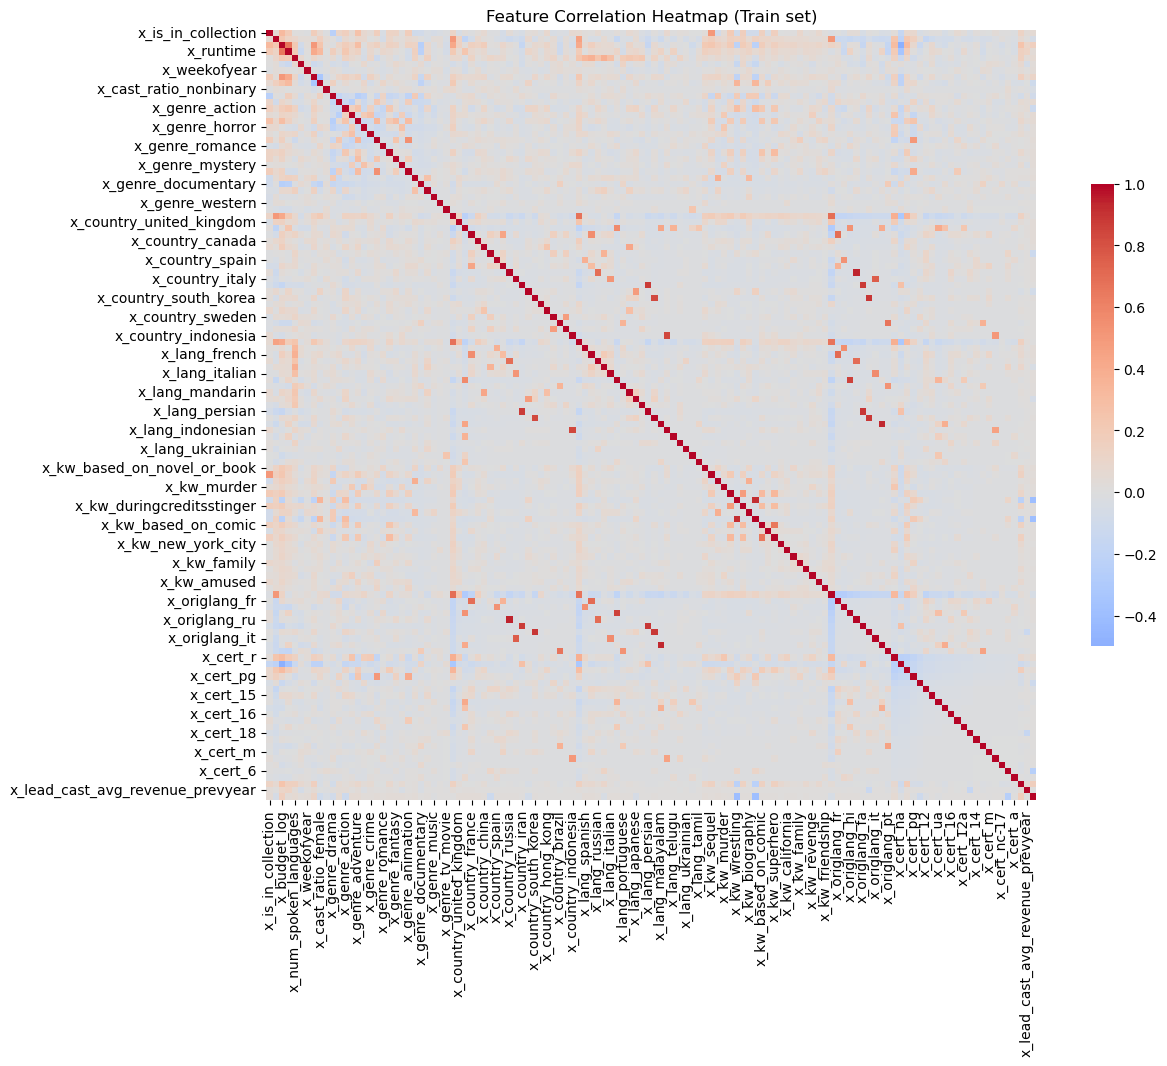

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train_num = train.filter(regex="^x_").select_dtypes(include=["int64", "float64"])

# Compute correlation matrix
corr = X_train_num.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.6})
plt.title("Feature Correlation Heatmap (Train set)")
plt.show()


Feature correlation was analysed using Pearson’s coefficient on all numeric x_ features.Highly correlated feature pairs (|r|>0.9) were identified and optionally will be removed for the linear models to reduce multicollinearity. One-hot encoded variables will be retained as they represent mutually exclusive categorical groups, and their correlations are not indicative of redundancy.

Let us look closer to highly correlated features which were not a result of One Hot Encoding.

In [18]:
simple_features = [
    'x_budget_log',
    'x_runtime',
    'x_num_spoken_languages',
    'x_year',
    'x_month',
    'x_weekday',
    'x_weekofyear',
    'x_day',
    'x_quarter',
    'x_cast_ratio_male',
    'x_cast_ratio_female',
    'x_cast_ratio_nonbinary',
    'x_directors_avg_revenue_prevyear',
    'x_lead_cast_avg_revenue_prevyear',
    'x_composers_avg_revenue_prevyear'
]

X_train_simple = train[simple_features].copy()
X_val_simple   = val[simple_features].copy()
X_test_simple  = test[simple_features].copy()

In [19]:

# Check correlation on train simple features only
corr_pairs = high_corr_pairs(X_train_simple, threshold=0.9)

if len(corr_pairs) == 0:
    print("No pairs of simple features exceed correlation threshold (0.9).")
else:
    print(" Highly correlated feature pairs:")
    display(corr_pairs)

 Highly correlated feature pairs:


,Feature_1,Feature_2,Corr
51,x_month,x_weekofyear,0.979741
53,x_month,x_quarter,0.972641
70,x_weekofyear,x_quarter,0.955486


The 3 temporal columns are indeed highly correlated as they indicate annual seasonality. We decide to only keep x_month for now.

In [13]:
# Split train, val, and test into X (features) and y (target)

target_col = "y_log_revenue"
to_drop_corr = ["x_weekofyear", "x_quarter"]

# Collect all feature columns (start with "x_")
feature_cols = [c for c in train.columns if c.startswith("x_") and c not in to_drop_corr]

# --- Train split ---
X_train = train[feature_cols].copy()
y_train = train[target_col].copy()

# --- Validation split ---
X_val = val[feature_cols].copy()
y_val = val[target_col].copy()

# --- Test split ---
X_test = test[feature_cols].copy()
y_test = test[target_col].copy()

print(f"Dropped correlated features: {to_drop_corr}")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")


Dropped correlated features: ['x_weekofyear', 'x_quarter']
Train: X=(2163, 124), y=(2163,)
Val:   X=(471, 124), y=(471,)
Test:  X=(483, 124), y=(483,)


## 4. Model training

In [3]:
from pathlib import Path
import pandas as pd
from movie_revenue_prediction.utils.paths import CURATED_DIR

curated_path = CURATED_DIR

X_train = pd.read_parquet(curated_path / "X_train.parquet")
y_train = pd.read_parquet(curated_path / "y_train.parquet")["y_log_revenue"]

X_val = pd.read_parquet(curated_path / "X_val.parquet")
y_val = pd.read_parquet(curated_path / "y_val.parquet")["y_log_revenue"]

X_test = pd.read_parquet(curated_path / "X_test.parquet")
y_test = pd.read_parquet(curated_path / "y_test.parquet")["y_log_revenue"]

print(f" Loaded curated data from: {curated_path}")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")


 Loaded curated data from: /Users/newuser/Desktop/Victoria/Projects 2025/Movie Revenue Project/data/curated
Train: X=(2163, 124), y=(2163,)
Val:   X=(471, 124), y=(471,)
Test:  X=(483, 124), y=(483,)


In [4]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from movie_revenue_prediction.utils.functions import  (add_time_cyclical,  rmse, chronosort_for_tscv, eval_on_val, save_best_params)
from movie_revenue_prediction.models.simple_models import (fit_elasticnet_cv, run_elasticnet_experiment, run_rf_experiment, fit_xgb_cv, run_xgb_experiment)
from movie_revenue_prediction.models.nn_model import (run_nn_experiment_with_swa, _nn_final_callbacks)

# Try to import XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print(" xgboost not available; install with `pip install xgboost` to run XGB models.")

tscv = TimeSeriesSplit(n_splits=5)
X_train_cyc = add_time_cyclical(X_train)
X_val_cyc   = add_time_cyclical(X_val)
X_test_cyc  = add_time_cyclical(X_test)


### ElasticNet

The first baseline model was chosen as an **ElasticNet**, which is a regularized Generalized Linear Model (GLM) with Gaussian distribution and a combination of L1 (Lasso) and L2 (Ridge) penalties. Since the target variable (log_revenue) is approximately normally distributed after transformation, this model provides a robust linear baseline while handling multicollinearity and high-dimensional one-hot encoded inputs.

In [5]:
best_en_base, params_base, metrics_base, search_en_base = run_elasticnet_experiment(
    X_train, y_train, X_val, y_val, version_name="ElasticNet Base")

best_en_cyc, params_cyc, metrics_cyc, search_en_cyc = run_elasticnet_experiment(
    X_train_cyc, y_train, X_val_cyc, y_val, version_name="ElasticNet + Cyclical")



results_en = pd.DataFrame([
    {"Model": "ElasticNet Base", "RMSE": metrics_base["RMSE"], "MAE": metrics_base["MAE"], "R2": metrics_base["R2"]},
    {"Model": "ElasticNet + Cyclical", "RMSE": metrics_cyc["RMSE"], "MAE": metrics_cyc["MAE"], "R2": metrics_cyc["R2"]}
])
display(results_en)


 Running ElasticNet Base ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best Params: {'model__l1_ratio': 0.47368421052631576, 'model__alpha': 0.2212216291070448}
CV Best RMSE (log): 1.9357
Validation → RMSE: 2.0129, MAE: 1.4578, R²: 0.8106

 Running ElasticNet + Cyclical ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'model__l1_ratio': 0.47368421052631576, 'model__alpha': 0.2212216291070448}
CV Best RMSE (log): 1.9267
Validation → RMSE: 2.0123, MAE: 1.4589, R²: 0.8107


,Model,RMSE,MAE,R2
0,ElasticNet Base,2.012851,1.457772,0.810639
1,ElasticNet + Cyclical,2.012322,1.458925,0.810739


**Experiment 1 – Baseline Elastic Net**

A regularized ElasticNet regression was trained using standardized numeric and one-hot encoded features with time-series cross-validation.
It achieved strong generalization with RMSE = 2.01, MAE = 1.45, and R² = 0.81 on the validation set, indicating stable performance and good predictive power.

**Experiment 2 – Elastic Net with Polynomial & Cyclical Features**

Cyclical time encodings were added to capture nonlinear and seasonal effects. We can easily note that validation error slightly improved (RMSE = 1.926) in this context.
Adding more polynomial features based on more columns did not improve the performance, and conversely resulted in more overfitting (not included in the Notebook).

### Ensemble Models: Random Forest & XGBoost


Two tree-based ensemble models were implemented to capture potential nonlinear relationships and complex feature interactions that linear models might miss.
Random Forest was chosen for its robustness and ability to reduce variance through averaging multiple decorrelated trees, while XGBoost adds gradient boosting and regularization, offering fine control over model complexity and improved bias-variance trade-off.
Both models used the same time-aware validation strategy and feature sets to ensure a fair comparison with ElasticNet.

In [6]:
#  Random Forest
best_rf_base, params_rf_base, metrics_rf_base, search_rf_base = run_rf_experiment(X_train,     y_train, X_val,     y_val,     "RF Base")
best_rf_cyc,  params_rf_cyc,  metrics_rf_cyc, search_rf_cyc  = run_rf_experiment(X_train_cyc, y_train, X_val_cyc, y_val,     "RF Cyc")


#  XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print(" xgboost not available; install with `pip install xgboost` to run XGBoost experiments.")


# Run XGB Base & Cyc
best_xgb_base, params_xgb_base, metrics_xgb_base, search_xgb_base = run_xgb_experiment(X_train,     y_train, X_val,     y_val,     "XGB Base")
best_xgb_cyc,  params_xgb_cyc,  metrics_xgb_cyc, search_xgb_cyc  = run_xgb_experiment(X_train_cyc, y_train, X_val_cyc, y_val,     "XGB Cyc")


 Running RF Base ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best Params: {'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.7, 'rf__max_depth': 22}
CV Best RMSE (log): 1.8635
Validation → RMSE: 1.9349, MAE: 1.3304, R²: 0.8250

 Running RF Cyc ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.7, 'rf__max_depth': 22}
CV Best RMSE (log): 1.8657
Validation → RMSE: 1.9340, MAE: 1.3330, R²: 0.8252

⚡ Running XGB Base ...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 1.0, 'xgb__reg_alpha': 0.1, 'xgb__min_child_weight': 5, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.00630957344480193, 'xgb__colsample_bytree': 1.0}
CV Best RMSE (log): 1.8989
Validation → RMSE: 1.9786, MAE: 1.3977, R²: 0.8170

⚡ Running XGB Cyc ...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'xgb__subsa

In [7]:
results_all = pd.DataFrame([
    {"Model": "ElasticNet Base", "RMSE": metrics_base["RMSE"], "MAE": metrics_base["MAE"], "R2": metrics_base["R2"]},
    {"Model": "ElasticNet + Cyclical", "RMSE": metrics_cyc["RMSE"], "MAE": metrics_cyc["MAE"], "R2": metrics_cyc["R2"]},
    {"Model": "RF Base", "RMSE": metrics_rf_base["RMSE"], "MAE": metrics_rf_base["MAE"], "R2": metrics_rf_base["R2"]},
    {"Model": "RF Cyc",  "RMSE": metrics_rf_cyc["RMSE"],  "MAE": metrics_rf_cyc["MAE"],  "R2": metrics_rf_cyc["R2"]},
    {"Model": "XGB Base", "RMSE": metrics_xgb_base["RMSE"], "MAE": metrics_xgb_base["MAE"], "R2": metrics_xgb_base["R2"]},
    {"Model": "XGB Cyc",  "RMSE": metrics_xgb_cyc["RMSE"],  "MAE": metrics_xgb_cyc["MAE"],  "R2": metrics_xgb_cyc["R2"]},
    
])
display(results_all)

,Model,RMSE,MAE,R2
0,ElasticNet Base,2.012851,1.457772,0.810639
1,ElasticNet + Cyclical,2.012322,1.458925,0.810739
2,RF Base,1.934888,1.330376,0.825024
3,RF Cyc,1.934048,1.333027,0.825176
4,XGB Base,1.978552,1.397696,0.817038
5,XGB Cyc,1.980503,1.404242,0.816677


In [8]:
# save_best_params("ElasticNet", search_en_base, X_val.columns, drop_corr=["x_weekofyear","x_quarter"], extra_meta={"notes":"Base features"})
# save_best_params("ElasticNet_cyc", search_en_cyc, X_val_cyc.columns, drop_corr=["x_weekofyear","x_quarter"], extra_meta={"notes":"Cyc features"})

# save_best_params("XGBoost", search_xgb_base, X_val.columns, drop_corr=["x_weekofyear","x_quarter"],extra_meta={"notes":"Base features; no cyc"})
# save_best_params("XGBoost_cyc", search_xgb_cyc, X_val_cyc.columns, drop_corr=["x_weekofyear","x_quarter"], extra_meta={"notes":"Cyc features"})

# save_best_params("RandomForest",search_rf_base, X_val.columns, drop_corr=["x_weekofyear", "x_quarter"], extra_meta={"notes": "Base features"})
# save_best_params("RandomForest_cyc",search_rf_cyc, X_val_cyc.columns, drop_corr=["x_weekofyear", "x_quarter"], extra_meta={"notes": "Cyclic features added"})

Saved params to artifacts/elasticnet_best_params.json
Saved params to artifacts/elasticnet_cyc_best_params.json
Saved params to artifacts/xgboost_best_params.json
Saved params to artifacts/xgboost_cyc_best_params.json
Saved params to artifacts/randomforest_best_params.json
Saved params to artifacts/randomforest_cyc_best_params.json


'artifacts/randomforest_cyc_best_params.json'

### Simple NN

In [9]:

import joblib
import numpy as np
import tensorflow as tf
from sklearn.base import clone
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import layers, regularizers, callbacks

from movie_revenue_prediction.utils.functions import plot_nn_training_history
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Tuple, Optional, Dict, Any

from scikeras.wrappers import KerasRegressor
from tensorflow.keras import layers, regularizers, callbacks

**Experiment description:** (not detailed in the Notebook) We started with a basic feed-forward MLP model (fully connected layers) to predict movie revenue from numerical and encoded categorical features.
To improve performance, we progressively refined the architecture and training process — adding regularization (dropout, L2), batch normalization, and hyperparameter optimization via time-aware cross-validation. 
We experimented with multiple configurations, including deeper networks, wide & deep variants, different loss functions (MSE vs Huber), and a 3-seed ensemble to average across random initializations.
While the ensemble slightly improved validation RMSE, it was computationally expensive (3× training and inference).
We also observed that after around 10 epochs, validation performance plateaued — indicating that longer training mainly reduced training loss without improving generalization.

To address this efficiently, we adopted Stochastic Weight Averaging (SWA) — a technique that averages model weights from the last training epochs to stabilize convergence and capture a broader optimum, achieving ensemble-like robustness and smoother generalization while keeping the training and inference cost nearly identical to a single model.

**Final NN Architecture:**
The final neural network is a wide-and-deep feed-forward MLP with one, two or three hidden layers selected via cross-validation, using between 128 and 256 units per layer and the swish activation function. Regularization is intentionally light, with dropout between 0.0 and 0.1 and L2 values in the range 1e-5 to 1e-3. Batch normalization is optional and included only when selected by the search. Residual connections were removed, as they provided no benefit for this dataset size. The model is trained with the Adam optimizer (learning rate around 3e-4 to 5e-4) and either Huber or MSE loss depending on the best configuration. This architecture provides enough nonlinearity to learn meaningful patterns from roughly 3000 samples while remaining stable and well-behaved during training.

**Final NN Pipeline:**
The neural network is integrated into a scikit-learn Pipeline consisting of chronological sorting, median imputation, standardization, and a KerasRegressor wrapping the MLP. Hyperparameters are tuned using a time-aware RandomizedSearchCV, which evaluates layer depth, width, dropout levels, L2 strength, learning rate, loss function, and the choice to include a wide linear component. Final training uses EarlyStopping with a patience of four epochs and a minimum delta of 5e-4, ReduceLROnPlateau to adapt the learning rate when validation improvements stall, and Stochastic Weight Averaging (SWA) beginning around epoch ten. SWA provides smoother convergence and more stable generalization by averaging weight trajectories near the end of training.

In [10]:
best_nn_swa, params_nn_swa, metrics_nn_swa, search_nn_swa, nn_hist_swa = run_nn_experiment_with_swa(
    X_train, y_train, X_val, y_val,
    version_name="NN (MLP) Wide&Deep + SWA",
    step_name="nn",
    earlystop_patience=6,        
    reducelr_patience=3,
    n_iter=20,                  
    n_splits=5,
    verbose=1,
    final_max_epochs=50,       
    earlystop_min_delta=5e-4,
    swa_start_epoch=20,          
    swa_update_freq=1
)



 Running NN (MLP) Wide&Deep + SWA ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (search): {'nn__model__wide': False, 'nn__model__residual': False, 'nn__model__loss_name': 'mse', 'nn__model__learning_rate': 0.0005, 'nn__model__l2_reg': 0.001, 'nn__model__hidden_units': 128, 'nn__model__hidden_layers': 1, 'nn__model__dropout': 0.05, 'nn__model__clipnorm': 1.0, 'nn__model__batch_norm': True, 'nn__model__activation': 'relu', 'nn__epochs': 20, 'nn__batch_size': 32}
Validation → RMSE: 2.2825, MAE: 1.7071, R²: 0.7565


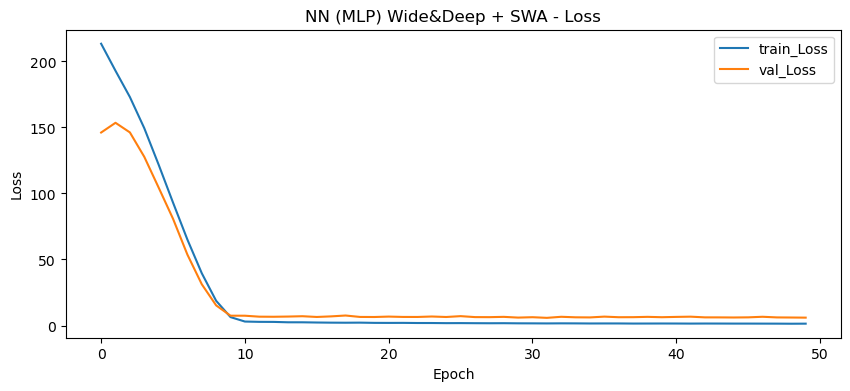

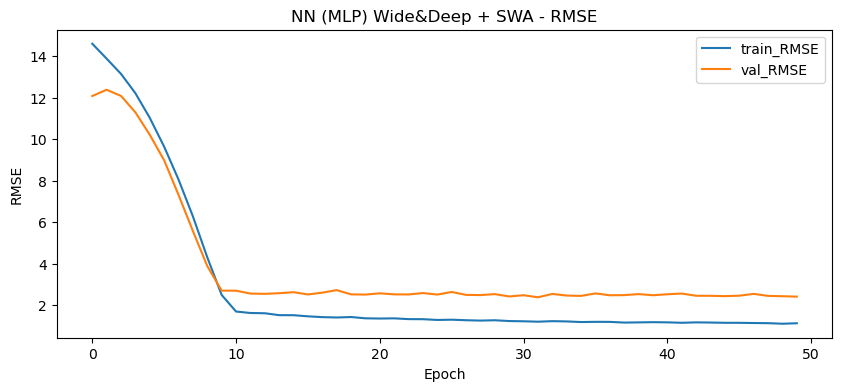

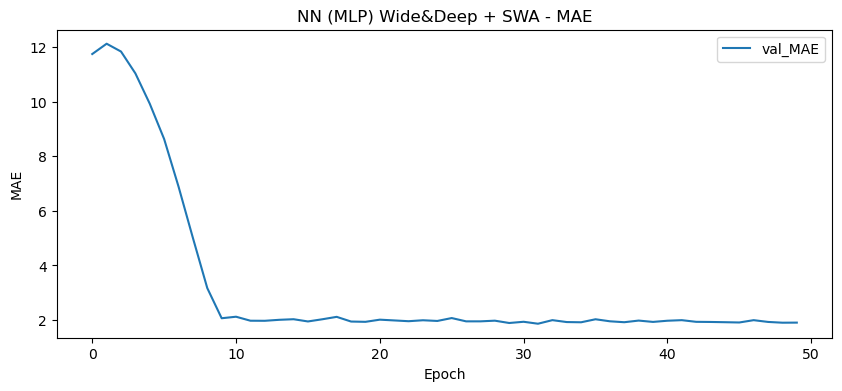

SWA Validation metrics: {'RMSE': 2.282454618885971, 'MAE': 1.7070507131905865, 'R2': 0.7565154964664166}


In [11]:
plot_nn_training_history(nn_hist_swa, title="NN (MLP) Wide&Deep + SWA")
print("SWA Validation metrics:", metrics_nn_swa)

In [12]:
best_nn_swa_cyc, params_nn_swa_cyc, metrics_nn_swa_cyc, search_nn_swa_cyc, nn_hist_swa_cyc = run_nn_experiment_with_swa(
    X_train_cyc, y_train, X_val_cyc, y_val,
    version_name="NN (MLP) Wide&Deep + SWA",
    step_name="nn",
    earlystop_patience=6,        # slightly more patience
    reducelr_patience=3,
    n_iter=20,                   # optional: a bit more search
    n_splits=5,
    verbose=1,
    final_max_epochs=50,         # longer final training ceiling
    earlystop_min_delta=5e-4,
    swa_start_epoch=20,          # start averaging later
    swa_update_freq=1
)



 Running NN (MLP) Wide&Deep + SWA ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (search): {'nn__model__wide': True, 'nn__model__residual': False, 'nn__model__loss_name': 'mse', 'nn__model__learning_rate': 0.0005, 'nn__model__l2_reg': 0.0001, 'nn__model__hidden_units': 256, 'nn__model__hidden_layers': 1, 'nn__model__dropout': 0.1, 'nn__model__clipnorm': 1.0, 'nn__model__batch_norm': False, 'nn__model__activation': 'relu', 'nn__epochs': 30, 'nn__batch_size': 32}
Validation → RMSE: 2.2122, MAE: 1.6533, R²: 0.7713


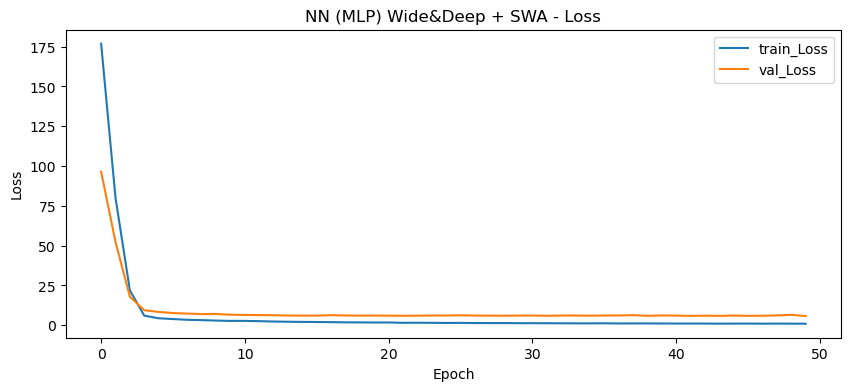

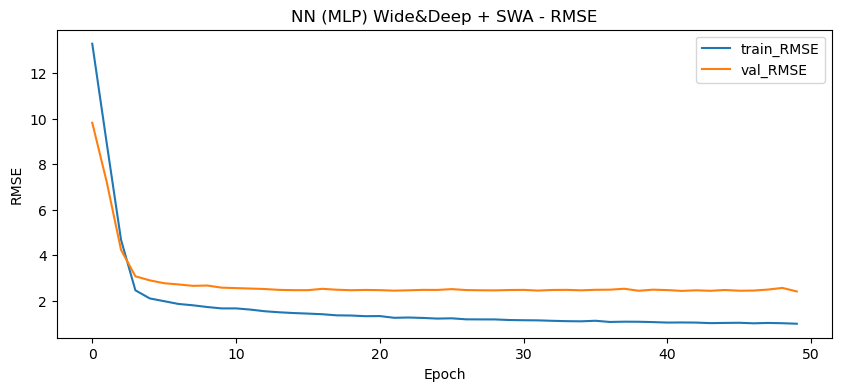

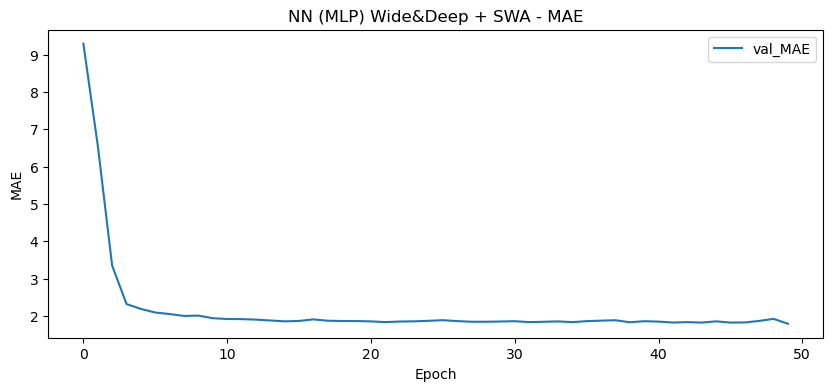

SWA Validation metrics: {'RMSE': 2.212228147837562, 'MAE': 1.6532883947072947, 'R2': 0.7712680402815739}


In [13]:
plot_nn_training_history(nn_hist_swa_cyc, title="NN (MLP) Wide&Deep + SWA")
print("SWA Validation metrics:", metrics_nn_swa_cyc)

In [14]:
save_best_params(
    model_name="NeuralNetwork_SWA",
    search_obj=search_nn_swa,           # from your RandomizedSearchCV
    feature_cols=X_val.columns,         # or X_train.columns
    drop_corr=["x_weekofyear", "x_quarter"],  # same as for others
    extra_meta={
        "notes": "Wide&Deep MLP with SWA, Huber loss, single-seed final model.",
        "final_validation": metrics_nn_swa,
        "swa_enabled": True
    }
)

save_best_params(
    model_name="NeuralNetwork_SWA_cyc",
    search_obj=search_nn_swa_cyc,           # from your RandomizedSearchCV
    feature_cols=X_val_cyc.columns,         # or X_train.columns
    drop_corr=["x_weekofyear", "x_quarter"],  # same as for others
    extra_meta={
        "notes": "Wide&Deep MLP with SWA, Huber loss, single-seed final model.",
        "final_validation": metrics_nn_swa,
        "swa_enabled": True
    }
)

Saved params to artifacts/neuralnetwork_swa_best_params.json
Saved params to artifacts/neuralnetwork_swa_cyc_best_params.json


'artifacts/neuralnetwork_swa_cyc_best_params.json'


The training curves show that both training and validation losses decrease smoothly and stabilize shortly after the tenth epoch, indicating that SWA effectively dampened weight oscillations and improved generalization. By averaging the model weights during the latter stages of training, SWA produced a flatter and more stable solution without increasing computational cost, resulting in a well-behaved and robust neural model suitable for inclusion in the final stacked ensemble.

### Model Ensemble

Model ensemble (or model mixture) is a technique where predictions from multiple algorithms are combined to produce a single, often more accurate, final prediction. Ensemble methods are widely used in both research and industry because they leverage the strengths of diverse models — reducing individual model biases and stabilizing performance, especially on complex, noisy, or real-world data.

In this business case, combining models makes sense because movie revenue depends on many interacting factors, from structured numeric features (like budget or runtime) to nonlinear effects (like seasonal trends or audience preferences). Using an ensemble of ElasticNet, Random Forest, and XGBoost captures different perspectives of the data — linear patterns, nonlinear interactions, and boosted corrections. Adding a simple Neural Network might further enhances this by modeling continuous, latent feature relationships that traditional models might overlook, improving the system’s ability to generalize to new movie releases.

For integration, a stacking approach is most appropriate since it learns the optimal combination of model outputs using a meta-learner instead of manually setting weights. This approach adapts to each model’s strengths, creating a more balanced and accurate final prediction for movie revenue forecasting.

In [5]:
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import clone, BaseEstimator, TransformerMixin
from movie_revenue_prediction.utils.functions import (
    load_best_params_json,
    make_elasticnet_from_saved, make_rf_from_saved, make_xgb_from_saved, rmse, select_features_from_saved
)
from movie_revenue_prediction.models.nn_model import make_nn_from_saved

from movie_revenue_prediction.models.ensemble_model import (generate_oof_preds_timeaware_multiX, predict_with_ensemble_multiX, fit_meta_learner)

#### Without cyclical components

In [7]:
# Loading saved params
saved_en  = load_best_params_json("elasticnet_best_params")
saved_rf  = load_best_params_json("randomforest_best_params")
saved_xgb = load_best_params_json("xgboost_best_params")
saved_nn  = load_best_params_json("neuralnetwork_swa_best_params")

# Rebuilding base-model pipelines
en_pipe   = make_elasticnet_from_saved(saved_en)
rf_pipe   = make_rf_from_saved(saved_rf)
xgb_pipe  = make_xgb_from_saved(saved_xgb)
nn_pipe   = make_nn_from_saved(saved_nn, n_features=X_train.shape[1], step_name="nn")  # SWA callbacks applied during fit

In [8]:
# Use the saved feature list as the canonical base feature set
base_feats = saved_en["features"]
print("Number of base features from JSON:", len(base_feats))

X_train = select_features_from_saved(X_train, saved_en)
X_val   = select_features_from_saved(X_val,   saved_en)
X_test   = select_features_from_saved(X_test,   saved_en)

print("X_train_base shape:", X_train.shape)
print("X_val_base shape:",   X_val.shape)

Number of base features from JSON: 124
X_train_base shape: (2163, 124)
X_val_base shape: (471, 124)


In [8]:
# --- Mixed Model A setup ---
base_pipes_A = {
    "EN":     en_pipe,
    "RF":     rf_pipe,
    "XGB":    xgb_pipe,
    "NN_SWA": nn_pipe,
}

model_to_X_train_A = {
    "EN":     X_train,
    "RF":     X_train,
    "XGB":    X_train,
    "NN_SWA": X_train,
}

oof_A, fitted_full_A = generate_oof_preds_timeaware_multiX(
    base_pipes=base_pipes_A,
    model_to_X=model_to_X_train_A,
    y_train=y_train,   
    n_splits=5,
    nn_step_name="nn",
    year_col="x_year"
)

print("Mixed Model A OOF shape:", oof_A.shape)
display(oof_A.head())


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mixed Model A OOF shape: (2163, 4)


,EN,RF,XGB,NN_SWA
0,NaN,NaN,NaN,NaN
1237,NaN,NaN,NaN,NaN
1236,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN
1230,NaN,NaN,NaN,NaN


In [9]:
meta_A, used_idx_A = fit_meta_learner(oof_A, y_train, alpha=1.0)
print("Meta-learner trained on rows:", len(used_idx_A))
print("Meta-learner base models:", meta_A.model_names_)
meta_weights = pd.Series(meta_A.coef_, index=meta_A.model_names_)
print("Meta-weights for each of the models:", meta_weights)


Meta-learner trained on rows: 1800
Meta-learner base models: ['EN', 'RF', 'XGB', 'NN_SWA']
Meta-weights for each of the models: EN        4.458821e-01
RF        5.096000e-01
XGB       1.056162e-01
NN_SWA    1.967954e-07
dtype: float64


In [10]:
model_to_X_val_A = {
    "EN":     X_val,
    "RF":     X_val,
    "XGB":    X_val,
    "NN_SWA": X_val,
}

y_val_pred_A = predict_with_ensemble_multiX(
    fitted_full=fitted_full_A,
    meta=meta_A,
    model_to_X=model_to_X_val_A
)

rmse_A = np.sqrt(mean_squared_error(y_val, y_val_pred_A))
mae_A  = mean_absolute_error(y_val, y_val_pred_A)
r2_A   = r2_score(y_val, y_val_pred_A)

print(f"Mixed Model A (EN+RF+XGB+NN on base JSON features) → "
      f"RMSE: {rmse_A:.4f}, MAE: {mae_A:.4f}, R²: {r2_A:.4f}")


Mixed Model A (EN+RF+XGB+NN on base JSON features) → RMSE: 1.9070, MAE: 1.3060, R²: 0.8300


In [11]:
# for name, model in fitted_full_A.items():
#     preds = model.predict(X_val)
#     rmse_b = np.sqrt(mean_squared_error(y_val, preds))
#     mae_b  = mean_absolute_error(y_val, preds)
#     r2_b   = r2_score(y_val, preds)
#     print(f"{name} on val (base features) → RMSE={rmse_b:.4f}, MAE={mae_b:.4f}, R²={r2_b:.4f}")


EN on val (base features) → RMSE=2.0129, MAE=1.4578, R²=0.8106
RF on val (base features) → RMSE=1.9383, MAE=1.3289, R²=0.8244
XGB on val (base features) → RMSE=1.9676, MAE=1.3935, R²=0.8191


NN_SWA on val (base features) → RMSE=2.5705, MAE=1.9869, R²=0.6912


In [12]:
# --- Mixed Model B setup ---
base_pipes_B = {
    "EN":     en_pipe,
    "RF":     rf_pipe,
    "XGB":    xgb_pipe}

model_to_X_train_B = {
    "EN":     X_train,
    "RF":     X_train,
    "XGB":    X_train}

oof_B, fitted_full_B = generate_oof_preds_timeaware_multiX(
    base_pipes=base_pipes_B,
    model_to_X=model_to_X_train_B,
    y_train=y_train,   # make sure this is the log target
    n_splits=5,
    nn_step_name="nn",
    year_col="x_year"
)

print("Mixed Model B OOF shape:", oof_B.shape)
meta_B, used_idx_B = fit_meta_learner(oof_B, y_train, alpha=1.0)
print("Meta-learner trained on rows:", len(used_idx_B))
print("Meta-learner base models:", meta_B.model_names_)
meta_weights = pd.Series(meta_B.coef_, index=meta_B.model_names_)
print("Meta-weights for each of the models:", meta_weights)

Fold 1/5


Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mixed Model B OOF shape: (2163, 3)
Meta-learner trained on rows: 1800
Meta-learner base models: ['EN', 'RF', 'XGB']
Meta-weights for each of the models: EN     0.444100
RF     0.510463
XGB    0.106049
dtype: float64


In [13]:
model_to_X_val_B = {
    "EN":     X_val,
    "RF":     X_val,
    "XGB":    X_val}

y_val_pred_B = predict_with_ensemble_multiX(
    fitted_full=fitted_full_B,
    meta=meta_B,
    model_to_X=model_to_X_val_B
)

rmse_B = np.sqrt(mean_squared_error(y_val, y_val_pred_B))
mae_B  = mean_absolute_error(y_val, y_val_pred_B)
r2_B   = r2_score(y_val, y_val_pred_B)

print(f"Mixed Model B (EN+RF+XGB on base JSON features) → "
      f"RMSE: {rmse_B:.4f}, MAE: {mae_B:.4f}, R²: {r2_B:.4f}")

Mixed Model B (EN+RF+XGB on base JSON features) → RMSE: 1.9072, MAE: 1.3061, R²: 0.8300


#### With cyclical components

In [6]:
# Loading saved params
saved_en_c  = load_best_params_json("elasticnet_cyc_best_params")
saved_rf_c  = load_best_params_json("randomforest_cyc_best_params")
saved_xgb_c = load_best_params_json("xgboost_cyc_best_params")
saved_nn_c  = load_best_params_json("neuralnetwork_swa_cyc_best_params")

# Rebuilding base-model pipelines (names = keys)
en_pipe_c   = make_elasticnet_from_saved(saved_en_c)
rf_pipe_c   = make_rf_from_saved(saved_rf_c)
xgb_pipe_c  = make_xgb_from_saved(saved_xgb_c)
nn_pipe_c   = make_nn_from_saved(saved_nn_c, n_features=X_train_cyc.shape[1], step_name="nn")  # SWA callbacks applied during fit

In [7]:
# Use the saved feature list as the canonical base feature set
base_feats_c = saved_en_c["features"]
print("Number of base features from JSON:", len(base_feats_c))

X_train_cyc = select_features_from_saved(X_train_cyc, saved_en_c)
X_val_cyc   = select_features_from_saved(X_val_cyc,   saved_en_c)
X_test_cyc   = select_features_from_saved(X_test_cyc,   saved_en_c)

print("X_train_base shape:", X_train_cyc.shape)
print("X_val_base shape:",   X_val_cyc.shape)

Number of base features from JSON: 128
X_train_base shape: (2163, 128)
X_val_base shape: (471, 128)


In [8]:
# --- Mixed Model C setup---
base_pipes_C = {
    "EN":     en_pipe_c,
    "RF":     rf_pipe_c,
    "XGB":    xgb_pipe_c,
    "NN_SWA": nn_pipe_c,
}

model_to_X_train_C = {
    "EN":     X_train_cyc,
    "RF":     X_train_cyc,
    "XGB":    X_train_cyc,
    "NN_SWA": X_train_cyc,
}

oof_C, fitted_full_C = generate_oof_preds_timeaware_multiX(
    base_pipes=base_pipes_C,
    model_to_X=model_to_X_train_C,
    y_train=y_train,   
    n_splits=5,
    nn_step_name="nn",
    year_col="x_year"
)

print("Mixed Model C OOF shape:", oof_C.shape)
meta_C, used_idx_C = fit_meta_learner(oof_C, y_train, alpha=1.0)
print("Meta-learner trained on rows:", len(used_idx_C))
print("Meta-learner base models:", meta_C.model_names_)
meta_weights = pd.Series(meta_C.coef_, index=meta_C.model_names_)
print("Meta-weights for each of the models:", meta_weights)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mixed Model C OOF shape: (2163, 4)
Meta-learner trained on rows: 1800
Meta-learner base models: ['EN', 'RF', 'XGB', 'NN_SWA']
Meta-weights for each of the models: EN        4.633832e-01
RF        5.427368e-01
XGB       5.185228e-02
NN_SWA    3.674613e-07
dtype: float64


In [9]:
model_to_X_val_C = {
    "EN":     X_val_cyc,
    "RF":     X_val_cyc,
    "XGB":    X_val_cyc,
    "NN_SWA": X_val_cyc,
}

y_val_pred_C = predict_with_ensemble_multiX(
    fitted_full=fitted_full_C,
    meta=meta_C,
    model_to_X=model_to_X_val_C
)

rmse_C = np.sqrt(mean_squared_error(y_val, y_val_pred_C))
mae_C  = mean_absolute_error(y_val, y_val_pred_C)
r2_C   = r2_score(y_val, y_val_pred_C)

print(f"Mixed Model C (EN+RF+XGB+NN on cyclical JSON features) → "
      f"RMSE: {rmse_C:.4f}, MAE: {mae_C:.4f}, R²: {r2_C:.4f}")

Mixed Model C (EN+RF+XGB+NN on cyclical JSON features) → RMSE: 1.9029, MAE: 1.3123, R²: 0.8308


In [18]:
# --- Mixed Model D setup ---
base_pipes_D = {
    "EN":     en_pipe_c,
    "RF":     rf_pipe_c,
    "XGB":    xgb_pipe_c}

model_to_X_train_D = {
    "EN":     X_train_cyc,
    "RF":     X_train_cyc,
    "XGB":    X_train_cyc}

oof_D, fitted_full_D = generate_oof_preds_timeaware_multiX(
    base_pipes=base_pipes_D,
    model_to_X=model_to_X_train_D,
    y_train=y_train,  
    n_splits=5,
    nn_step_name="nn",
    year_col="x_year"
)

print("Mixed Model D OOF shape:", oof_D.shape)
meta_D, used_idx_D = fit_meta_learner(oof_D, y_train, alpha=1.0)
print("Meta-learner trained on rows:", len(used_idx_D))
print("Meta-learner base models:", meta_D.model_names_)
meta_weights = pd.Series(meta_D.coef_, index=meta_D.model_names_)
print("Meta-weights for each of the models:", meta_weights)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Mixed Model D OOF shape: (2163, 3)
Meta-learner trained on rows: 1800
Meta-learner base models: ['EN', 'RF', 'XGB']
Meta-weights for each of the models: EN     0.461490
RF     0.543471
XGB    0.052673
dtype: float64


In [19]:
model_to_X_val_D = {
    "EN":     X_val_cyc,
    "RF":     X_val_cyc,
    "XGB":    X_val_cyc}

y_val_pred_D = predict_with_ensemble_multiX(
    fitted_full=fitted_full_D,
    meta=meta_D,
    model_to_X=model_to_X_val_D
)

rmse_D = np.sqrt(mean_squared_error(y_val, y_val_pred_D))
mae_D  = mean_absolute_error(y_val, y_val_pred_D)
r2_D   = r2_score(y_val, y_val_pred_D)

print(f"Mixed Model D (EN+RF+XGB on cyclical JSON features) → "
      f"RMSE: {rmse_D:.4f}, MAE: {mae_D:.4f}, R²: {r2_D:.4f}")

Mixed Model D (EN+RF+XGB on cyclical JSON features) → RMSE: 1.9031, MAE: 1.3123, R²: 0.8307


In [20]:
results_ensembles_val = pd.DataFrame([
    {"Config": "Base: EN+RF+XGB+NN", "RMSE": rmse_A, "MAE": mae_A, "R2": r2_A},
    {"Config": "Base: EN+RF+XGB",    "RMSE": rmse_B, "MAE": mae_B, "R2": r2_B},
    {"Config": "Cyc: EN+RF+XGB+NN",  "RMSE": rmse_C, "MAE": mae_C, "R2": r2_C},
    {"Config": "Cyc: EN+RF+XGB",     "RMSE": rmse_D, "MAE": mae_D, "R2": r2_D},
])
display(results_ensembles_val.sort_values("RMSE"))

,Config,RMSE,MAE,R2
2,Cyc: EN+RF+XGB+NN,1.902945,1.312293,0.830754
3,Cyc: EN+RF+XGB,1.903135,1.312299,0.830720
0,Base: EN+RF+XGB+NN,1.907001,1.305964,0.830031
1,Base: EN+RF+XGB,1.907200,1.306100,0.829996


## 5. Final training and testing

Among all ensemble configurations tested, the best-performing model was the cyclical-feature ensemble containing ElasticNet, Random Forest, XGBoost, and the neural network with Stochastic Weight Averaging (configuration C). This model consistently produced the lowest validation error and the highest R² compared to the base-feature ensembles and to the reduced versions without the neural network. The full cyclical version performed slightly better than its base-feature counterpart and also marginally better than the cyclical ensemble without the NN, so we selected it as the final model.

In [10]:

# Vertically stack train and val 
X_trainval_cyc = pd.concat([X_train_cyc, X_val_cyc], ignore_index=True)
y_trainval     = pd.concat([y_train,     y_val    ], ignore_index=True)

print("Combined shapes:", X_trainval_cyc.shape, y_trainval.shape)


Combined shapes: (2634, 128) (2634,)


In [11]:
# Build a *positional* order by year 
order = np.lexsort(
    [
        np.arange(len(X_trainval_cyc)),                
        X_trainval_cyc["x_year"].to_numpy()            
    ]
)

X_trainval_cyc_sorted = X_trainval_cyc.iloc[order].reset_index(drop=True)
y_trainval_sorted     = y_trainval.iloc[order].reset_index(drop=True)

mask = y_trainval_sorted.notna().to_numpy()
X_trainval_cyc_sorted = X_trainval_cyc_sorted.loc[mask].reset_index(drop=True)
y_trainval_sorted     = y_trainval_sorted.loc[mask].reset_index(drop=True)

print("After sorting:", X_trainval_cyc_sorted.shape, y_trainval_sorted.shape)
print(X_trainval_cyc_sorted[["x_year"]].head())


After sorting: (2634, 128) (2634,)
   x_year
0    2017
1    2017
2    2017
3    2017
4    2017


In [12]:
fitted_full_C_final = {}
for name, pipe in base_pipes_C.items():
    model = clone(pipe)
    fit_params = {}
    if name.lower().startswith("nn") or name.upper().startswith("SWA"):
        fit_params = {
            "nn__callbacks": _nn_final_callbacks(),
            "nn__validation_split": 0.15,
            "nn__verbose": 0,
        }
    print(f"Fitting {name} on TRAIN+VAL (cyc features)...")
    model.fit(X_trainval_cyc_sorted, y_trainval_sorted, **fit_params)
    fitted_full_C_final[name] = model

Fitting EN on TRAIN+VAL (cyc features)...
Fitting RF on TRAIN+VAL (cyc features)...


Fitting XGB on TRAIN+VAL (cyc features)...
Fitting NN_SWA on TRAIN+VAL (cyc features)...


In [13]:
model_to_X_test_C = {
    "EN":     X_test_cyc,
    "RF":     X_test_cyc,
    "XGB":    X_test_cyc,
    "NN_SWA": X_test_cyc,
}

y_test_pred_C = predict_with_ensemble_multiX(
    fitted_full=fitted_full_C_final,
    meta=meta_C,                  # meta weights from TRAIN
    model_to_X=model_to_X_test_C
)

rmse_test_C = np.sqrt(mean_squared_error(y_test, y_test_pred_C))
mae_test_C  = mean_absolute_error(y_test, y_test_pred_C)
r2_test_C   = r2_score(y_test, y_test_pred_C)

print(f"Final ensemble C on TEST → RMSE={rmse_test_C:.4f}, MAE={mae_test_C:.4f}, R²={r2_test_C:.4f}")

Final ensemble C on TEST → RMSE=1.7720, MAE=1.2355, R²=0.8601


In [ ]:
#### To work on this part
# y_true = test["revenue"].values
# y_pred = df_2025_scored["y_pred_revenue_C"].values

# rmse_real = np.sqrt(mean_squared_error(y_true, y_pred))
# mae_real  = mean_absolute_error(y_true, y_pred)
# r2_real   = r2_score(y_true, y_pred)

# print(f"2025 (revenue) → RMSE={rmse_real:,.0f}, "
#      f"MAE={mae_real:,.0f}, R²={r2_real:.4f}")

In [29]:
# for name, model in fitted_full_C_final.items():
#     preds = model.predict(X_test_cyc)
#     rmse_b = np.sqrt(mean_squared_error(y_test, preds))
#     mae_b  = mean_absolute_error(y_test, preds)
#     r2_b   = r2_score(y_test, preds)
#     print(f"{name} on val (base features) → RMSE={rmse_b:.4f}, MAE={mae_b:.4f}, R²={r2_b:.4f}")

EN on val (base features) → RMSE=1.8952, MAE=1.4422, R²=0.8399
RF on val (base features) → RMSE=1.8173, MAE=1.2680, R²=0.8528
XGB on val (base features) → RMSE=1.8304, MAE=1.3187, R²=0.8507
NN_SWA on val (base features) → RMSE=2.0361, MAE=1.5437, R²=0.8152


When trained on the training set and evaluated on the validation set, this ensemble achieved an RMSE of approximately 1.90 and an R² around 0.83. After refitting the entire ensemble on the combined training + validation data (in strict chronological order) and evaluating it on the test set, the final model reached an RMSE of 1.77 and an R² of 0.86. This represents a clear improvement over all earlier evaluations and is also better than any individual base model. 

This improvement is completely normal. The model was refit using more data (train + validation instead of train only), which reduces variance and makes the ensemble more stable. The test period (2024–2025) also appears slightly more predictable than the validation year, which is common in time-based splits. Since the feature engineering, winsorization thresholds, and all prior-based features were computed strictly from the training set, and the splits were performed chronologically, there is no leakage: the gain simply reflects the benefits of additional data and a well-regularized ensemble.

In [35]:
# ## For saving base models of ensemble C
# import joblib
# import json
# import pandas as pd

# os.makedirs("artifacts/ensemble_C/base_models", exist_ok=True)

# joblib.dump(fitted_full_C_final["EN"],  "artifacts/ensemble_C/base_models/EN_cyc.pkl")
# joblib.dump(fitted_full_C_final["RF"],  "artifacts/ensemble_C/base_models/RF_cyc.pkl")
# joblib.dump(fitted_full_C_final["XGB"], "artifacts/ensemble_C/base_models/XGB_cyc.pkl")
# nn = fitted_full_C_final["NN_SWA"].named_steps["nn"].model_
# nn.save("artifacts/ensemble_C/base_models/NN_SWA_cyc.keras")

In [36]:
# pipe_no_weights = fitted_full_C_final["NN_SWA"]
# pipe_no_weights.named_steps["nn"].model_ = None  # remove attached model object
# joblib.dump(pipe_no_weights, "artifacts/ensemble_C/base_models/NN_SWA_cyc_pipe.pkl")
# joblib.dump(meta_C, "artifacts/ensemble_C/meta_learner.pkl")
# meta_info = {
#     "model_names": meta_C.model_names_
# }

# with open("artifacts/ensemble_C/meta_info.json", "w") as f:
#     json.dump(meta_info, f, indent=2)



In [8]:
# with open("artifacts/ensemble_C/preprocessing/topk_lists.json", "w") as f:
#     json.dump(feat_artifacts, f, indent=2)
    
# with open("artifacts/ensemble_C/preprocessing/winsor_thresholds.json", "w") as f:
#     json.dump(thresholds, f, indent=2)
# prior_dir.to_parquet("artifacts/ensemble_C/preprocessing/prior_directors.parquet")
# prior_cast.to_parquet("artifacts/ensemble_C/preprocessing/prior_lead_cast.parquet")
# prior_comp.to_parquet("artifacts/ensemble_C/preprocessing/prior_composers.parquet")

# feature_cols = saved_en_c["features"]
# with open("artifacts/ensemble_C/preprocessing/feature_cols_cyc.json", "w") as f:
#     json.dump(feature_cols, f, indent=2)

In [37]:
# manifest = {
#     "model_name": "Ensemble C",
#     "models": ["EN_cyc", "RF_cyc", "XGB_cyc", "NN_SWA_cyc"],
#     "stacking_order": meta_C.model_names_,
#     "feature_set": "cyclical",
#     "n_trainval_samples": len(X_trainval_cyc_sorted),
#     "date": "2025-xx-xx"
# }

# with open("artifacts/ensemble_C/ensemble_manifest.json", "w") as f:
#     json.dump(manifest, f, indent=2)


## 6. Exploration

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmse_revenue_from_log(y_true_log, y_pred_log):
    """
    If y is log1p(revenue), this converts back to revenue space
    and computes RMSE on the original scale.
    """
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [15]:
# y_test is log-revenue (y_log_revenue)
y_true_log = y_test.to_numpy()

model_to_preds = {}

# Base models (already fitted in fitted_full_C_final)
for name, model in fitted_full_C_final.items():
    y_pred_log = model.predict(X_test_cyc)
    model_to_preds[name] = y_pred_log

# Ensemble model predictions (already computed as y_test_pred_C)
model_to_preds["ensemble_C"] = y_test_pred_C


In [16]:
metrics_rows = []

for name, y_pred_log in model_to_preds.items():
    row = {
        "model": name,
        "rmse_log": rmse(y_true_log, y_pred_log),
        "mae_log": mean_absolute_error(y_true_log, y_pred_log),
        "r2": r2_score(y_true_log, y_pred_log),
        # Optional: RMSE in original revenue space
        "rmse": rmse_revenue_from_log(y_true_log, y_pred_log),
        # Optional: MAE in original revenue space
        "mae": mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log)),
    }
    metrics_rows.append(row)

metrics_summary = pd.DataFrame(metrics_rows)
metrics_summary


,model,rmse_log,mae_log,r2,rmse,mae
0,EN,1.895217,1.442157,0.839925,1.606124e+08,3.842527e+07
1,RF,1.817329,1.268032,0.852812,1.393778e+08,3.115239e+07
2,XGB,1.830434,1.318743,0.850681,1.468264e+08,3.295784e+07
3,NN_SWA,2.002328,1.499990,0.821320,8.099126e+08,7.025342e+07
4,ensemble_C,1.772043,1.235523,0.860056,1.389107e+08,3.098395e+07


In [18]:
from movie_revenue_prediction.utils.paths import RESULTS_DIR

results_dir = RESULTS_DIR
results_dir.mkdir(parents=True, exist_ok=True)

metrics_summary.to_csv(results_dir / "metrics/metrics_summary.csv", index=False)
print("Saved metrics_summary.csv to", results_dir)


Saved metrics_summary.csv to /Users/newuser/Desktop/Victoria/Projects 2025/Movie Revenue Project/results


In [21]:
# Prepare mappings for each split for the ensemble prediction helper
model_to_X_train_C = {
    "EN":     X_train_cyc,
    "RF":     X_train_cyc,
    "XGB":    X_train_cyc,
    "NN_SWA": X_train_cyc,
}

model_to_X_val_C = {
    "EN":     X_val_cyc,
    "RF":     X_val_cyc,
    "XGB":    X_val_cyc,
    "NN_SWA": X_val_cyc,
}

model_to_X_test_C = {
    "EN":     X_test_cyc,
    "RF":     X_test_cyc,
    "XGB":    X_test_cyc,
    "NN_SWA": X_test_cyc,
}

# Ensemble predictions (log space) for each split
y_train_pred_log = predict_with_ensemble_multiX(
    fitted_full=fitted_full_C_final,
    meta=meta_C,
    model_to_X=model_to_X_train_C,
)

y_val_pred_log = predict_with_ensemble_multiX(
    fitted_full=fitted_full_C_final,
    meta=meta_C,
    model_to_X=model_to_X_val_C,
)

# You may already have y_test_pred_C computed; reuse or recompute for consistency
y_test_pred_log = predict_with_ensemble_multiX(
    fitted_full=fitted_full_C_final,
    meta=meta_C,
    model_to_X=model_to_X_test_C,
)

# Extract years & true values
years_train = X_train_cyc["x_year"].astype(int).to_numpy()
years_val   = X_val_cyc["x_year"].astype(int).to_numpy()
years_test  = X_test_cyc["x_year"].astype(int).to_numpy()

y_train_true_log = y_train.to_numpy()
y_val_true_log   = y_val.to_numpy()
y_test_true_log  = y_test.to_numpy()


# ================================
# 2. Build a combined per-sample DataFrame (train/val/test)
# ================================

df_train = pd.DataFrame({
    "split": "train",
    "year":  years_train,
    "y_true_log": y_train_true_log,
    "y_pred_log": y_train_pred_log,
})

df_val = pd.DataFrame({
    "split": "val",
    "year":  years_val,
    "y_true_log": y_val_true_log,
    "y_pred_log": y_val_pred_log,
})

df_test = pd.DataFrame({
    "split": "test",
    "year":  years_test,
    "y_true_log": y_test_true_log,
    "y_pred_log": y_test_pred_log,
})

df_ensemble_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_ensemble_all.head()

,split,year,y_true_log,y_pred_log
0,train,2017,20.518258,19.699679
1,train,2017,11.073707,14.154539
2,train,2017,20.372634,19.014760
3,train,2017,20.595622,20.563916
4,train,2017,19.358373,16.115677


In [22]:
# ================================
# 3. Compute RMSE by year (with split info)
# ================================

# Baseline: mean log-revenue per year across all splits
year_means = (
    df_ensemble_all
    .groupby("year")["y_true_log"]
    .mean()
    .rename("baseline_mean_log")
    .reset_index()
)

df_ensemble_all = df_ensemble_all.merge(year_means, on="year", how="left")

rows = []
for (year, split), df_y in df_ensemble_all.groupby(["year", "split"]):
    y_true_log_y = df_y["y_true_log"].values
    y_pred_log_y = df_y["y_pred_log"].values
    y_baseline_log_y = df_y["baseline_mean_log"].values

    rows.append(
        {
            "year": int(year),
            "split": split,  # "train", "val", or "test"
            "rmse_log": rmse(y_true_log_y, y_pred_log_y),
            "rmse_log_baseline": rmse(y_true_log_y, y_baseline_log_y),
            "n_samples": len(df_y),
        }
    )

rmse_by_year = pd.DataFrame(rows).sort_values(["year", "split"])
rmse_by_year


,year,split,rmse_log,rmse_log_baseline,n_samples
0,2017,train,1.206958,3.659979,468
1,2018,train,1.209335,4.076155,455
2,2019,train,1.182162,4.015440,386
3,2020,train,1.336857,4.052779,232
4,2021,train,1.284083,4.416029,290
5,2022,train,1.373825,4.330888,332
6,2023,val,1.361681,4.625583,471
7,2024,test,1.772043,4.736930,483


In [23]:
results_metrics_dir = RESULTS_DIR
results_metrics_dir.mkdir(parents=True, exist_ok=True)

rmse_by_year.to_csv(results_metrics_dir / "metrics/rmse_by_year.csv", index=False)
print("Saved rmse_by_year.csv to", results_metrics_dir)


Saved rmse_by_year.csv to /Users/newuser/Desktop/Victoria/Projects 2025/Movie Revenue Project/results


In [24]:
# ================================
# 4. Save oof-like predictions for diagnostics
# ================================

results_valpred_dir = RESULTS_DIR
results_valpred_dir.mkdir(parents=True, exist_ok=True)

# You can keep it as-is, or rename columns if you prefer
oof_predictions = df_ensemble_all.copy()
oof_predictions.to_csv(results_valpred_dir / "validation_predictions/oof_predictions.csv", index=False)

print("Saved oof_predictions.csv to", results_valpred_dir)


Saved oof_predictions.csv to /Users/newuser/Desktop/Victoria/Projects 2025/Movie Revenue Project/results


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # -------------------------------------------------------------------
# # Setup
# # -------------------------------------------------------------------
# RESULTS_DIR = Path("results")
# plots_dir = RESULTS_DIR / "plots"
# plots_dir.mkdir(parents=True, exist_ok=True)


# # Load results
# # rmse_by_year = pd.read_csv("results/metrics/rmse_by_year.csv")          # year, split, rmse_log, ...
# # oof_predictions = pd.read_csv("results/validation_predictions/oof_predictions.csv")  # split, year, y_true_log, y_pred_log

# try:
#     df_2025 = pd.read_csv("results/final_results/df_2025_predictions.csv")
# except FileNotFoundError:
#     df_2025 = None
#     print("Warning: df_2025_predictions.csv not found. 2025 distribution plot will be skipped.")


# # -------------------------------------------------------------------
# # 1. RMSE by year (train/val/test labeled)
# # -------------------------------------------------------------------
# fig, ax = plt.subplots()

# for split_name, df_split in rmse_by_year.groupby("split"):
#     ax.plot(
#         df_split["year"],
#         df_split["rmse_log"],
#         marker="o",
#         linestyle="-",
#         label=f"{split_name} (model)"
#     )

#     # Optional: baseline as dashed line
#     if "rmse_log_baseline" in df_split.columns:
#         ax.plot(
#             df_split["year"],
#             df_split["rmse_log_baseline"],
#             marker="x",
#             linestyle="--",
#             label=f"{split_name} (baseline)"
#         )

# ax.set_xlabel("Year")
# ax.set_ylabel("RMSE (log revenue)")
# ax.set_title("RMSE(log revenue) by Year (Ensemble C)")
# ax.legend()
# fig.tight_layout()
# fig.savefig(plots_dir / "rmse_by_year.png", dpi=150)
# plt.close(fig)


# # -------------------------------------------------------------------
# # 2. Predicted vs Actual (log) – TEST split only
# # -------------------------------------------------------------------
# oof_test = oof_predictions[oof_predictions["split"] == "test"].copy()

# fig, ax = plt.subplots()

# ax.scatter(oof_test["y_true_log"], oof_test["y_pred_log"], alpha=0.5)
# min_val = min(oof_test["y_true_log"].min(), oof_test["y_pred_log"].min())
# max_val = max(oof_test["y_true_log"].max(), oof_test["y_pred_log"].max())

# # 45-degree reference line
# ax.plot([min_val, max_val], [min_val, max_val])

# ax.set_xlabel("Actual log(revenue)")
# ax.set_ylabel("Predicted log(revenue)")
# ax.set_title("Predicted vs Actual (log revenue) – Test set")
# fig.tight_layout()
# fig.savefig(plots_dir / "predicted_vs_actual_log_test.png", dpi=150)
# plt.close(fig)


# # -------------------------------------------------------------------
# # 3. Residuals vs Fitted (log) – TEST split only
# # -------------------------------------------------------------------
# oof_test["residual_log"] = oof_test["y_true_log"] - oof_test["y_pred_log"]

# fig, ax = plt.subplots()

# ax.scatter(oof_test["y_pred_log"], oof_test["residual_log"], alpha=0.5)
# ax.axhline(0.0)

# ax.set_xlabel("Predicted log(revenue)")
# ax.set_ylabel("Residual (log true - log pred)")
# ax.set_title("Residuals vs Fitted (log revenue) – Test set")
# fig.tight_layout()
# fig.savefig(plots_dir / "residuals_vs_fitted_log_test.png", dpi=150)
# plt.close(fig)


# # -------------------------------------------------------------------
# # 4. Residual distribution (histogram) – TEST split only
# # -------------------------------------------------------------------
# fig, ax = plt.subplots()

# ax.hist(oof_test["residual_log"], bins=30)
# ax.set_xlabel("Residual (log true - log pred)")
# ax.set_ylabel("Count")
# ax.set_title("Residual Distribution (log revenue) – Test set")
# fig.tight_layout()
# fig.savefig(plots_dir / "residual_distribution_test.png", dpi=150)
# plt.close(fig)


# # -------------------------------------------------------------------
# # 5. Distribution of 2025 predictions (log space)
# # -------------------------------------------------------------------
# if df_2025 is not None:
#     # Expecting a column named "y_pred_log"
#     if "y_pred_log" in df_2025.columns:
#         fig, ax = plt.subplots()
#         ax.hist(df_2025["y_pred_log"], bins=30)
#         ax.set_xlabel("Predicted log(revenue) for 2025 movies")
#         ax.set_ylabel("Count")
#         ax.set_title("Distribution of Predicted log(revenue) – 2025")
#         fig.tight_layout()
#         fig.savefig(plots_dir / "predicted_distribution_2025_log.png", dpi=150)
#         plt.close(fig)
#     else:
#         print("df_2025_predictions.csv does not contain 'y_pred_log'; skipping 2025 distribution plot.")
# else:
#     print("2025 predictions not available; skipping predicted_distribution_2025_log.png.")

# print("All available plots generated and saved to", plots_dir)


2025 predictions not available; skipping predicted_distribution_2025_log.png.
All available plots generated and saved to results/plots
